## [E12] 트랜스포머로 만드는 대화형 챗봇



### 참고 사이트
- 아이펠의 Exploration 12 노드
- [고려대학교 산업경영공학부 DSBA연구실|08-2:Transformer](https://www.youtube.com/watch?v=Yk1tV_cXMMU)
- [Positional Encoding in NLP](https://inmoonlight.github.io/2020/01/26/Positional-Encoding/)


-------------------
![](https://jalammar.github.io/images/t/the_transformer_3.png)
![](https://jalammar.github.io/images/t/The_transformer_encoders_decoders.png)
![](https://jalammar.github.io/images/t/The_transformer_encoder_decoder_stack.png)

In [195]:
# 한국어 폰트 설치를 확인합니다.  
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 


In [73]:
import tensorflow as tf
import tensorflow_datasets as tfds
import pandas as pd
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import time
from tensorflow.keras.utils import plot_model
%matplotlib inline

## 1. 모델 구성
### 1-1. Positional encoding
단어를 임베딩 벡터로 변환하는 벡터화 과정을 거치는데, 트랜스포머의 경우는 임베딩하고 난 이후에 positional encoding을 임베딩 벡터에 더해준다.
- RNN은 단어를 문장에 위치하는 순서대로 입력되니까 따로 어순을 알려주지 않아도 되지만, __트랜스포머는 한꺼번에 모든 단어를 문장 단위로 입력하기 때문에 위치정보를 가진 벡터(positinal encoding)를 더해줘서 모델에 입력__ 해준다. 

- 좋은 Positional encoding scheme은 다음과 같은 두가지 특징을 갖고 있다. 
    1. 해당하는 encoding vector의 크기 자체는 동일해야한다.      
     - word embedding에 똑같은 크기로 더해줘야 동일한 벡터 크기가같은 벡터가 더해져서 모든 word들이 같은 방향 같은 크기로 변화한다는 보장을 할수 있다. 
    2. input sequence에 포함된 두 단어의 거리가 sequence 안에서 멀어지면, positional encoding vector 사이의 거리도 멀어져야 한다. 
    
    
- 여러가지 positional encoding vector가 있지만 "Attention is all you need"에서 사용된 PE(혹은 sinusoidal functions)는 sin, cos 함수를 사용하여서 만든다. 
- 

$$PE_{(pos, 2i)}=sin(pos/10000^{2i/d_{model}})$$
$$PE_{(pos, 2i+1)}=cos(pos/10000^{2i/d_{model}})$$

In [74]:
# 포지셔널 인코딩 레이어
class PositionalEncoding(tf.keras.layers.Layer):

    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(position, d_model)
    
    def get_angles(self, position, i, d_model):
        angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
        return position * angles
    
    def positional_encoding(self, position, d_model):
        # 각도 배열 생성
        angle_rads = self.get_angles(
            position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
            i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
            d_model=d_model)
        # 배열의 짝수 인덱스에는 sin 함수 적용
        sines = tf.math.sin(angle_rads[:, 0::2])
        # 배열의 홀수 인덱스에는 cosine 함수 적용
        cosines = tf.math.cos(angle_rads[:, 1::2])
        
        # sin과 cosine이 교차되도록 재배열
        pos_encoding = tf.stack([sines, cosines], axis=0)
        pos_encoding = tf.transpose(pos_encoding,[1, 2, 0]) 
        pos_encoding = tf.reshape(pos_encoding, [position, d_model])
        
        pos_encoding = pos_encoding[tf.newaxis, ...]
        return tf.cast(pos_encoding, tf.float32)
    
    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]


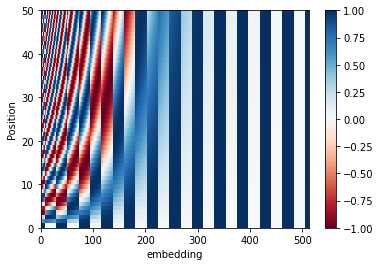

In [75]:
sample_pos_encoding = PositionalEncoding(50, 512)

plt.pcolormesh(sample_pos_encoding.pos_encoding.numpy()[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.xlabel("embedding")
plt.colorbar()
plt.show()

### 1-2. Scaled Dot Product Attention
![](https://media.vlpt.us/images/cha-suyeon/post/ba830026-6d8f-4e77-b288-f75dd3a51457/image.png)

In [76]:
# scaled dot prodcut attention
def scaled_dot_product_attention(query, key, value, mask):
    # query vector와 key vector의 dot product
    matmul_qk = tf.matmul(query, key, transpose_b=True) 
    
    # 가중치를 정규화 
    # key의 dimension
    depth = tf.cast(tf.shape(key)[-1], tf.float32)
    # key의 dimension을 루트 씌워서  matmul_pk로 나눠준다.
    logits = matmul_qk / tf.math.sqrt(depth) 
    
    # 패딩에 마스크 추가
    # encoder에 넣을 때는 마스크 빼고, decoder에 넣을 때는 마스크 추가
    if mask is not None:
        logits += (mask * -1e9)
        
    # softmax적용
    attention_weights = tf.nn.softmax(logits, axis=-1)
    
    # 최종 어텐션은 가중치와 V의 닷 프로덕
    output = tf.matmul(attention_weights, value)
    return output


### 1-3. Multi - head Attention

In [77]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, name="multi_head_attention"):
        super(MultiHeadAttention, self).__init__(name=name)
        self.num_heads = num_heads
        self.d_model = d_model
        
        assert d_model % self.num_heads == 0
        
        self.depth = d_model // self.num_heads
        
        self.query_dense = tf.keras.layers.Dense(units=d_model)
        self.key_dense = tf.keras.layers.Dense(units=d_model)
        self.value_dense = tf.keras.layers.Dense(units=d_model)
        
        self.dense = tf.keras.layers.Dense(units=d_model)
        
    def split_heads(self, inputs, batch_size):
        inputs = tf.reshape(
            inputs, shape=(batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(inputs, perm=[0, 2, 1, 3])
    
    def call(self, inputs):
        query, key, value, mask = inputs['query'], inputs['key'], inputs['value'], inputs['mask']
        batch_size = tf.shape(query)[0]
        
        # Q, K, V에 각각 Dense를 적용합니다
        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)
        
        # 병렬 연산을 위한 머리를 여러 개 만듭니다
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)
        
        # 스케일드 닷 프로덕트 어텐션 함수
        scaled_attention = scaled_dot_product_attention(query, key, value, mask)
        
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])
        
        # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)합니다
        concat_attention = tf.reshape(scaled_attention,(batch_size, -1, self.d_model))
        # 최종 결과에도 Dense를 한 번 더 적용합니다
        outputs = self.dense(concat_attention)
        
        return outputs


### 1-4. 패딩 마스킹 (padding masking)

- 패딩은 문장의 길이가 주어진 문장 길이보다 짧은 문장의 앞 혹은 뒤에 0으로 채워서 모든 문장의 길이를 동일하게 해주는 자연어 전처리이다.
- 패딩(0)처리가 된 위치를 표시하여 attention 연산을 실행할때 패딩을 포함 시키지 않는다. 그래서 padding masking 처리를 한다.

In [78]:
def create_padding_mask(x): # 패딩마스크
    mask = tf.cast(tf.math.equal(x, 0), tf.float32) # 의미 없는 0
    # (batch_size, 1, 1, sequence length)
    return mask[:, tf.newaxis, tf.newaxis, :]


In [79]:
# 숫자가 0인 곳만 1이 되고 나머지는 0이 된다. 
# attention 연산할때 1인 부분을 제외하고 연산하게 함.
print(create_padding_mask(tf.constant([[1, 2, 0, 3, 0], [0, 0, 0, 4, 5]])))

tf.Tensor(
[[[[0. 0. 1. 0. 1.]]]


 [[[1. 1. 1. 0. 0.]]]], shape=(2, 1, 1, 5), dtype=float32)


### 1-5. 룩 어헤드 마스킹(Look-ahead masking, 다음 단어 가리기)

In [80]:
def create_look_ahead_mask(x):
    seq_len = tf.shape(x)[1]
    look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
    padding_mask = create_padding_mask(x)
    return tf.maximum(look_ahead_mask, padding_mask)

print(create_look_ahead_mask(tf.constant([[1, 2, 3, 4, 5]])))

tf.Tensor(
[[[[0. 1. 1. 1. 1.]
   [0. 0. 1. 1. 1.]
   [0. 0. 0. 1. 1.]
   [0. 0. 0. 0. 1.]
   [0. 0. 0. 0. 0.]]]], shape=(1, 1, 5, 5), dtype=float32)


In [81]:
print(create_look_ahead_mask(tf.constant([[0, 5, 1, 5, 5]])))

tf.Tensor(
[[[[1. 1. 1. 1. 1.]
   [1. 0. 1. 1. 1.]
   [1. 0. 0. 1. 1.]
   [1. 0. 0. 0. 1.]
   [1. 0. 0. 0. 0.]]]], shape=(1, 1, 5, 5), dtype=float32)


### 1-6. 인코더
-  인코더 블록 및 인코더 생성     

In [82]:
# 인코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 두 개의 서브 레이어가 존재합니다.
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
    
    # 패딩 마스크 사용
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")
    # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
    attention = MultiHeadAttention(
        d_model, num_heads, name="attention")({
        'query': inputs,'key': inputs,'value': inputs,'mask': padding_mask})
    
    # 어텐션의 결과는 Dropout과 Layer Normalization이라는 훈련을 돕는 테크닉을 수행
    attention = tf.keras.layers.Dropout(rate=dropout)(attention)
    attention = tf.keras.layers.LayerNormalization(epsilon=1e-6)(inputs + attention)
    
    # 두 번째 서브 레이어 : 2개의 완전연결층
    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)
    
    # 완전연결층의 결과는 Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention + outputs)
    
    return tf.keras.Model(inputs=[inputs, padding_mask], outputs=outputs, name=name)


In [83]:
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")
    
    # 패딩 마스크 사용
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")
    
    # 임베딩 레이어
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
    # 포지셔널 인코딩
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)
    
    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)
    
    # num_layers만큼 쌓아올린 인코더의 층
    for i in range(num_layers):
        outputs = encoder_layer(units=units, d_model=d_model,
                                num_heads=num_heads,dropout=dropout,
                                name="encoder_layer_{}".format(i),)([outputs, padding_mask])
        return tf.keras.Model(inputs=[inputs, padding_mask], outputs=outputs, name=name)


### 1-7. 디코더
-  디코더 블록 및 디코더 생성     

In [84]:
# 디코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 세 개의 서브 레이어가 존재합니다.
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
    enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
    look_ahead_mask = tf.keras.Input(shape=(1, None, None), name="look_ahead_mask")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
    
    # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
    attention1 = MultiHeadAttention(
        d_model, num_heads, name="attention_1")(inputs={
        'query': inputs,'key': inputs,'value': inputs,'mask': look_ahead_mask})
    
    # 멀티 헤드 어텐션의 결과는 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    attention1 = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(attention1 + inputs)
    
    # 두 번째 서브 레이어 : 마스크드 멀티 헤드 어텐션 수행 (인코더-디코더 어텐션)
    attention2 = MultiHeadAttention(
        d_model, num_heads, name="attention_2")(inputs={
        'query': attention1,'key': enc_outputs,'value': enc_outputs,'mask': padding_mask})
    
    # 마스크드 멀티 헤드 어텐션의 결과는
    # Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
    attention2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention2 + attention1)
    
    # 세 번째 서브 레이어 : 2개의 완전연결층
    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)
    
    # 완전연결층의 결과는 Dropout과 LayerNormalization 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(outputs + attention2)
    
    return tf.keras.Model(
        inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
        outputs=outputs,
        name=name)


In [85]:
def decoder(vocab_size,num_layers,units,d_model,num_heads,dropout,name='decoder'):
    inputs = tf.keras.Input(shape=(None,), name='inputs')
    enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
    look_ahead_mask = tf.keras.Input(shape=(1, None, None), name='look_ahead_mask')
    
    # 패딩 마스크
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
    
    # 임베딩 레이어
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
    
    # 포지셔널 인코딩
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)
    
    # Dropout이라는 훈련을 돕는 테크닉을 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)
    
    for i in range(num_layers):
        outputs = decoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name='decoder_layer_{}'.format(i),
        )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])
        
    return tf.keras.Model(
        inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
        outputs=outputs,
        name=name)


## 2. 챗봇 데이터(cornell movie dialogs Corpus) 로드 및 전처리

- 데이터 출처: [송영숙님 깃허브의 songys/Chatbot_data 레포지토리](https://github.com/songys/Chatbot_data)
- [다음카페- 사랑보다 아름다운 실연](https://cafe.daum.net/ilovedlove)에서 자주 나오는 이야기를 참고하여 제작한 챗봇 데이터셋

- 챗봇 트레이닝용 문답 페어 11,876개
- 레이블링 (0: 일상다반사/ 1: 이별(부정)/ 2: 사랑(긍정))


### 2.1 데이터 로드

In [86]:
dir_=os.getenv('HOME')+'/aiffel/transformer_chatbot/data' 
df=pd.read_csv(dir_+'/ChatbotData .csv',encoding='utf-8')

In [87]:
df.head()

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0


In [88]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11823 entries, 0 to 11822
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Q       11823 non-null  object
 1   A       11823 non-null  object
 2   label   11823 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 277.2+ KB


### 2.2 결측치, 중복된 데이터 제거 및  데이터 EDA   
- 다음 코드와 같이 결측치는 없다.

In [89]:
df.isnull().sum() # 결측치는 없음

Q        0
A        0
label    0
dtype: int64

중복된 데이터는 삭제한다.

In [90]:
df=df.drop_duplicates()

#### 각 레이블의 데이터 개수
- 0: 일상다반사, 1: 이별(부정), 2: 사랑(긍정)

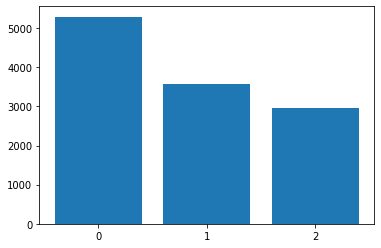

In [91]:
y=df["label"].value_counts()
x=y.index
plt.bar([0,1,2],y)
plt.xticks([0,1,2],x)
plt.show()

#### 각 레이블 별 데이터 확인

In [92]:
df.loc[df["label"]==0].head() # 일상적인 문답(사랑, 이별과 관련 없는 이야기)

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0


In [93]:
df.loc[df["label"]==1].head() # 이별관련 문답

,Q,A,label
5290,1000일 만난 여자친구와 이별,더 오래 만날 사람 만날 거예요.,1
5291,10년 연애. 헤어졌습니다.,더 공허함이 크시겠네요.,1
5292,10년 연애사 되돌아보니 다 부질없네,더 좋은 사람 만나실 거예요.,1
5293,10년 연예의끝,더 마음이 허하겠어요.,1
5294,10년만나다 헤어지네,충분히 슬퍼하고 충분히 아파하다가 이겨내세요.,1


In [94]:
df.loc[df["label"]==2].head() # 사랑 관련 문답

,Q,A,label
8860,짝사랑만큼 고통스러운 건 없겠지.,짝사랑 만큼 감정소모가 큰 건 없을 거예요.,2
8861,1년 넘게 만났는데 지금도 불타올라,정열적인 사랑을 하고 있나봐요.,2
8862,1년 동거 중인데 계속 좋아,서로 깊게 알게되면서 더 좋아졌나봅니다.,2
8863,1년 동거하고 결혼했어,축하합니다!,2
8864,1년 만났는데도 그 사람에 대해 잘 모르겠어,더 만나보세요.,2


8860번의 짝사랑도 사랑이긴 하지만 긍정적인 사랑이야기라고는 생각하기 힘들다. 일단은 챗봇을 만들기 위한 데이터 관찰이므로 넘기지만 만일 감정분류를 할때 이 데이터를 사용한다면 주의해야할 것 같다.

In [95]:
# 전처리 함수
def preprocess_sentence(sentence):
    sentence = sentence.strip()
    
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    
    # (ㄱ-ㅣ가-힣,A-Z,a-z, ".", "?", "!", ",")를 제외한 모든 문자를 공백인 ' '로 대체합니다.
    sentence = re.sub(r"[^ㄱ-ㅣ가-힣A-Za-z?.!,0-9]+", " ", sentence)
    sentence = sentence.strip()
    return sentence


- 한국어 데이터에 대한 전처리를 해야하므로 영어 전처리 할때 알파벳과 문장부호만 남기고 공백으로 바꾸는 코드에 __ㄱ-l(자음,모음)과 가-힣(모든 한국어 글자)들을 제외__ 하는 정규표현식을 추가해주어야한다.

In [96]:
df["Q"]=df["Q"].map(lambda x: preprocess_sentence(x)) # 질문 전처리함수 적용
df["A"]=df["A"].map(lambda x: preprocess_sentence(x)) # 답변 전처리함수 적용

In [97]:
df.head()

,Q,A,label
0,12시 땡 !,하루가 또 가네요 .,0
1,1지망 학교 떨어졌어,위로해 드립니다 .,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠 .,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠 .,0
4,PPL 심하네,눈살이 찌푸려지죠 .,0


### 불용어 제거

In [98]:
def remove_stopwords(seq):
    stopwords=['을', '한테', '이다' ,'의','가','이','은','들','는','좀','잘','걍','과',
               '도','를','으로','자','에','와','한','하다'] # 불용어 제거
    for i in seq:
        if i in stopwords:
            seq.pop(seq.index(i))
    return seq

- 불용어는 단어 단위이므로 일단 각 문장을 단어단위로 자른다.

In [99]:
# 각 문장을 띄어쓰기 단위로 자르기
df["Q_words"]=df["Q"].map(lambda x: x.split(" ")) 
df["A_words"]=df["A"].map(lambda x: x.split(" "))

- 불용어가 잘 삭제가 되는지 확인하기 위해서 질문에 불용어 "걍"이 포함된 문장의 일부를 보자

In [100]:
df.loc[df["Q"].str.contains("걍"),["Q_words","A_words"]].head()

,Q_words,A_words
5809,"[난, 나대로, 걍, 산다]","[나대로, 사는게, 좋죠, .]"
10245,"[썸, 타다가, 이제, 안, 볼, 거면, 걍, 잠수, 타, ?, 만나서, 말해, ?]","[애매함이, 좋은지, 생각해보세요, .]"


In [101]:
# 질문과 답변의 불용어 제거하기
df["Q_words"]=df["Q_words"].map(lambda x: remove_stopwords(x))
df["A_words"]=df["A_words"].map(lambda x: remove_stopwords(x))

- Q_words컬럼에 불용어 '이젠'이 사라진 것을 확인할 수 있다.

In [102]:
df.loc[df["Q"].str.contains("걍"),["Q_words","A_words"]].head()

,Q_words,A_words
5809,"[난, 나대로, 산다]","[나대로, 사는게, 좋죠, .]"
10245,"[썸, 타다가, 이제, 안, 볼, 거면, 잠수, 타, ?, 만나서, 말해, ?]","[애매함이, 좋은지, 생각해보세요, .]"


In [103]:
# 각 문장의 단어수
df["nQ"]=df["Q_words"].map(lambda x: len(x))
df["nA"]=df["A_words"].map(lambda x: len(x))

In [104]:
print("불용어 제거후 문장 길이가 0이 된 질문 데이터는 ",df.loc[df["nQ"]==0].shape[0],"개 이다.")
print("불용어 제거후 문장 길이가 0이 된 답변 데이터는 ",df.loc[df["nA"]==0].shape[0],"개 이다.")

불용어 제거후 문장 길이가 0이 된 질문 데이터는  0 개 이다.
불용어 제거후 문장 길이가 0이 된 답변 데이터는  0 개 이다.


In [105]:
s1=df.loc[df["nQ"]==0].index # 질문길이가 0이 된 문장의 인덱스
s2=df.loc[df["nA"]==0].index # 답변 길이가 0이 된 문장의 인덱스
# 질문길이가 0 혹은 답변길이가 0인 데이터의 인덱스
s=list(set(s1.tolist()) | set(s2.tolist()))
# 질문길이 혹은 답변 길이가 0인 데이터의 인덱스를 삭제하라
df=df.drop(s)


### 전처리한 질문과 답변을 문장으로 만든다.

In [106]:
questions=[" ".join(i) for i in df["Q_words"]]  
answers = [" ".join(i) for i in df["A_words"]]

In [107]:
df["Q"]=questions
df["A"]=answers

In [108]:
df.head()

,Q,A,label,Q_words,A_words,nQ,nA
0,12시 땡 !,하루가 또 가네요 .,0,"[12시, 땡, !]","[하루가, 또, 가네요, .]",3,4
1,1지망 학교 떨어졌어,위로해 드립니다 .,0,"[1지망, 학교, 떨어졌어]","[위로해, 드립니다, .]",3,3
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠 .,0,"[3박4일, 놀러가고, 싶다]","[여행은, 언제나, 좋죠, .]",3,4
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠 .,0,"[3박4일, 정도, 놀러가고, 싶다]","[여행은, 언제나, 좋죠, .]",4,4
4,PPL 심하네,눈살이 찌푸려지죠 .,0,"[PPL, 심하네]","[눈살이, 찌푸려지죠, .]",2,3


### 2-2. 단어장 만들기

In [109]:
import tensorflow_datasets as tfds

# 질문과 답변 데이터셋에 대해서 Vocabulary 생성. (Tensorflow 2.3.0 이상) (클라우드는 2.4 입니다)
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(questions + answers, target_vocab_size=2**13)

# 시작 토큰과 종료 토큰에 고유한 정수를 부여합니다.
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

# 시작 토큰과 종료 토큰을 고려하여 +2를 하여 단어장의 크기를 산정합니다.
VOCAB_SIZE = tokenizer.vocab_size + 2
print(VOCAB_SIZE)


8171


In [110]:
# 정수 인코딩,
def tokenize(x):
        return START_TOKEN + tokenizer.encode(x) + END_TOKEN

# 최대 길이를 초과하는 샘플 제거, 패딩
# 최대 길이 9 이하인 경우에만 데이터셋으로 허용
def filter_(inputs, outputs):
    tokenized_inputs, tokenized_outputs = [], []
    for (sentence1, sentence2) in zip(inputs, outputs):

        if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
            tokenized_inputs.append(sentence1)
            tokenized_outputs.append(sentence2)
        
    # 최대 길이 9으로 모든 데이터셋을 패딩
    tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
        tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
    tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
        tokenized_outputs, maxlen=MAX_LENGTH, padding='post')
    return tokenized_inputs, tokenized_outputs



In [111]:
# 임의의 22번째 샘플에 대해서 정수 인코딩 작업을 수행.
# 각 토큰을 고유한 정수로 변환
print('정수 인코딩 후의 22번째 질문 샘플: {}'.format(tokenizer.encode(questions[21])))
print('정수 인코딩 후의 22번째 답변 샘플: {}'.format(tokenizer.encode(answers[21])))

정수 인코딩 후의 22번째 질문 샘플: [5759, 634, 2485, 4158]
정수 인코딩 후의 22번째 답변 샘플: [2351, 7509, 7, 6271, 95, 1]


In [112]:
# 인코딩한 문답
df["Q_enc"]=df["Q"].map(lambda x: tokenize(x))
df["A_enc"]=df["A"].map(lambda x: tokenize(x))

#인코딩한 문답의 개수(시작,끝 토큰을 개수를 제외하기 위해서 -2를 한다)
df["nQ"]=df["Q_enc"].map(lambda x: len(x)-2)
df["nA"]=df["A_enc"].map(lambda x: len(x)-2)

In [113]:
df.head()

,Q,A,label,Q_words,A_words,nQ,nA,Q_enc,A_enc
0,12시 땡 !,하루가 또 가네요 .,0,"[12시, 땡, !]","[하루가, 또, 가네요, .]",4,4,"[8169, 7908, 4198, 3052, 38, 8170]","[8169, 4728, 75, 7887, 1, 8170]"
1,1지망 학교 떨어졌어,위로해 드립니다 .,0,"[1지망, 학교, 떨어졌어]","[위로해, 드립니다, .]",6,3,"[8169, 7962, 44, 913, 7945, 994, 1713, 8170]","[8169, 1824, 5495, 1, 8170]"
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠 .,0,"[3박4일, 놀러가고, 싶다]","[여행은, 언제나, 좋죠, .]",6,4,"[8169, 7964, 1434, 4644, 7945, 3645, 64, 8170]","[8169, 3394, 770, 129, 1, 8170]"
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠 .,0,"[3박4일, 정도, 놀러가고, 싶다]","[여행은, 언제나, 좋죠, .]",7,4,"[8169, 7964, 1434, 4644, 7945, 1293, 3645, 64,...","[8169, 3394, 770, 129, 1, 8170]"
4,PPL 심하네,눈살이 찌푸려지죠 .,0,"[PPL, 심하네]","[눈살이, 찌푸려지죠, .]",5,7,"[8169, 7993, 7993, 7989, 7945, 4181, 8170]","[8169, 875, 2292, 1491, 2178, 5463, 47, 1, 8170]"


### 문답 각각의 시퀀스의 단어수 분포(왼쪽:질문/ 오른쪽: 답)
- 최대 문장의 길이를 판단하기 위해서는 일단 __서브워드 텍스트 인코더(subword text encoder)로 토크나이즈를 해서 적절한 최대문장 길이를 생각해보자__ 
- 전체 데이터 분포 중에서 지나치게 긴 문장이 몇개 있다면 패딩이 너무 늘어나게 되어서 성능이 나빠진다.
- 최대 문장길이를 정하기 위해서 시퀀스의 단어수가 어떤 분포를 그리는지 체크해본다.

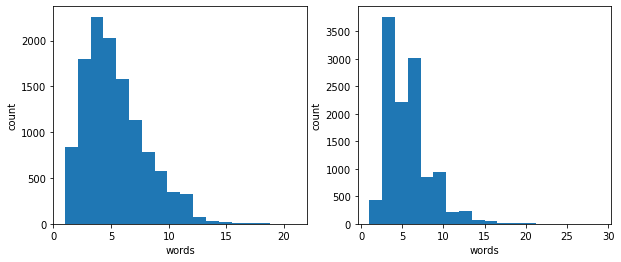

In [114]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.hist(df["nQ"], bins=18)
plt.ylabel("count")
plt.xlabel("words")

plt.subplot(1,2,2)
plt.hist(df["nA"], bins=18)
plt.ylabel("count")
plt.xlabel("words")

plt.show()

In [115]:
print("전체 문장의 수:", df.shape[0])

전체 문장의 수: 11823


In [116]:
print("질문 문장중 가장 긴 단어수:",df["nQ"].max(),"/ 대답 문장 중 가장 긴 단어수:", df["nA"].max())
print("질문 문장중 가장 짧은 단어수:",df["nQ"].min(),"/ 대답 문장 중 가장 짧은 단어수:", df["nA"].min())

질문 문장중 가장 긴 단어수: 21 / 대답 문장 중 가장 긴 단어수: 29
질문 문장중 가장 짧은 단어수: 1 / 대답 문장 중 가장 짧은 단어수: 1


In [117]:
print("전체 질문 중 97%에 해당하는 문장이",np.percentile(df["nQ"].values, 97) ,"개 이하의 단어로 이루어져있다")
print("전체 답변 중 97%에 해당하는 문장이",np.percentile(df["nA"].values, 97) ,"개 이하의 단어로 이루어져있다")

전체 질문 중 97%에 해당하는 문장이 11.0 개 이하의 단어로 이루어져있다
전체 답변 중 97%에 해당하는 문장이 12.0 개 이하의 단어로 이루어져있다


In [118]:
print("질문문장 중에서 11단어 이하인 문장의 개수: ",df.loc[df["nQ"]<=11].shape[0],"/ 11단어를 초과하는 문장 개수:",df.loc[df["nQ"]>11].shape[0]) 
print("답변문장 중에서 12단어 이하인 문장의 개수: ",df.loc[df["nA"]<=12].shape[0],"/ 12단어를 초과하는 문장 개수:",df.loc[df["nA"]>12].shape[0]) 

질문문장 중에서 11단어 이하인 문장의 개수:  11545 / 11단어를 초과하는 문장 개수: 278
답변문장 중에서 12단어 이하인 문장의 개수:  11559 / 12단어를 초과하는 문장 개수: 264


- 최대 문장길이를 11로 정하면 전체 데이터 중에서 3%만 삭제하고 패딩 개수를 절반 가까이 줄일수 있기 때문에 일단 문장의 최대길이를 11로 정해볼수 있겠다.

In [119]:
# 샘플의 최대 허용 길이 또는 패딩 후의 최종 길이
MAX_LENGTH = 11
print(MAX_LENGTH)

questions, answers=filter_(df["Q_enc"], df["A_enc"])
print('단어장의 크기 :',(VOCAB_SIZE))
print('필터링 후의 질문 샘플 개수: {}'.format(len(questions)))
print('필터링 후의 답변 샘플 개수: {}'.format(len(answers)))

11
단어장의 크기 : 8171
필터링 후의 질문 샘플 개수: 10165
필터링 후의 답변 샘플 개수: 10165


### 2-3. 교사강요(Teacher Forcing) 사용하기

In [120]:
BATCH_SIZE = 64
BUFFER_SIZE = 12000

# 디코더는 이전의 target을 다음의 input으로 사용합니다.
# 이에 따라 outputs에서는 START_TOKEN을 제거하겠습니다.
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1]
    },
    {
        'outputs': answers[:, 1:]
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)


## 3. 모델 정의 및 학습

### 3-1. 트랜스포머 정의

In [121]:
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
    
    inputs = tf.keras.Input(shape=(None,), name="inputs")
    dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

    # 인코더에서 패딩을 위한 마스크
    enc_padding_mask = tf.keras.layers.Lambda(create_padding_mask, output_shape=(1, 1, None),
                                              name='enc_padding_mask')(inputs)
    
    # 디코더에서 미래의 토큰을 마스크 하기 위해서 사용합니다.
    # 내부적으로 패딩 마스크도 포함되어져 있습니다.
    look_ahead_mask = tf.keras.layers.Lambda(create_look_ahead_mask,
                                             output_shape=(1, None, None),
                                             name='look_ahead_mask')(dec_inputs)
    
    # 두 번째 어텐션 블록에서 인코더의 벡터들을 마스킹
    # 디코더에서 패딩을 위한 마스크
    dec_padding_mask = tf.keras.layers.Lambda(create_padding_mask, output_shape=(1, 1, None),
                                              name='dec_padding_mask')(inputs)
    
    
    # 인코더
    enc_outputs = encoder(vocab_size=vocab_size,
                          num_layers=num_layers,
                          units=units,
                          d_model=d_model,
                          num_heads=num_heads,
                          dropout=dropout,)(inputs=[inputs, enc_padding_mask])
    
    # 디코더
    dec_outputs = decoder(vocab_size=vocab_size,
                          num_layers=num_layers,
                          units=units,
                          d_model=d_model,
                          num_heads=num_heads,
                          dropout=dropout,)(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])
    
    # 완전연결층
    outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)
    return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)


### 3-2. 손실함수
- 레이블이 문장이기 때문에 시퀀스에 패딩이 있다. 
- loss를 계산하기 위해서 패딩 마스크를 사용한다.

In [122]:
def loss_function(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')(y_true, y_pred)
    
    mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
    loss = tf.multiply(loss, mask)
    return tf.reduce_mean(loss)


### 3-3. 기본 모델 생성

In [123]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 2 # 인코더와 디코더의 층의 개수
D_MODEL = 256 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 256)    2618880     inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

### 3-4.Custom Learning rate Scheduling

In [124]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()
        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)
        self.warmup_steps = warmup_steps
    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps**-1.5)
        
        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)


- 커스텀 학습률 스케줄링 계획 시각화

Text(0.5, 0, 'Train Step')

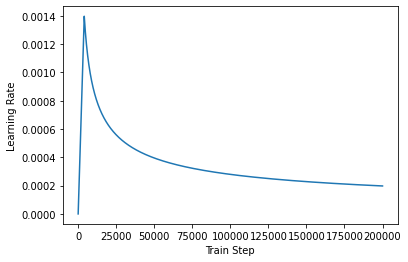

In [125]:
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

### 3-5. 기본 모델 컴파일

In [126]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
    return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])


### 3-6. 기본모델 훈련하기(epoch= 50)
- epoch이 20일때 학습이 거의 이루어지지 않아서 50으로 늘려서 훈련을 일단 시켜보았다.

In [127]:
model_time={}

start = time.time()  # 시작 시간 저장

EPOCHS = 50
model.fit(dataset, epochs=EPOCHS, verbose=0)

period=time.time() - start

model_time["model1"]=period

print("time :", period)

time : 188.46756267547607


## 4. 챗봇 테스트 하기

In [128]:
def decoder_inference(sentence, model):
    sentence = preprocess_sentence(sentence)
    
    # 입력된 문장을 정수 인코딩 후, 시작 토큰과 종료 토큰을 앞뒤로 추가.
    # ex) Where have you been? → [[8331   86   30    5 1059    7 8332]]
    sentence = tf.expand_dims(
        START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)
    
    # 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수.
    # 처음에는 예측한 내용이 없음으로 시작 토큰만 별도 저장. ex) 8331
    output_sequence = tf.expand_dims(START_TOKEN, 0)
    
    # 디코더의 인퍼런스 단계
    for i in range(MAX_LENGTH):
        # 디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측을 반복합니다.
        predictions = model(inputs=[sentence, output_sequence], training=False)
        predictions = predictions[:, -1:, :]
        
        # 현재 예측한 단어의 정수
        
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)
        
        # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
        if tf.equal(predicted_id, END_TOKEN[0]):
            break
            
        # 예측한 단어들은 지속적으로 output_sequence에 추가됩니다.
        # 이 output_sequence는 다시 디코더의 입력이 됩니다.
        
        output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)
    
    return tf.squeeze(output_sequence, axis=0)

In [129]:
def sentence_generation(sentence, model):
    # 입력 문장에 대해서 디코더를 동작 시켜 예측된 정수 시퀀스를 리턴받습니다.
    prediction = decoder_inference(sentence, model)
    
    # 정수 시퀀스를 다시 텍스트 시퀀스로 변환합니다.
    predicted_sentence = tokenizer.decode(
        [i for i in prediction if i < tokenizer.vocab_size])
    print('입력 : {}'.format(sentence))
    print('출력 : {}'.format(predicted_sentence))
    print("---"*20)
    
    return predicted_sentence


## 기본모델 도식화
- 코드가 지나치게 길어져서 모델의 구조를 볼겸 다음과 같이 도식화를 해보았다.

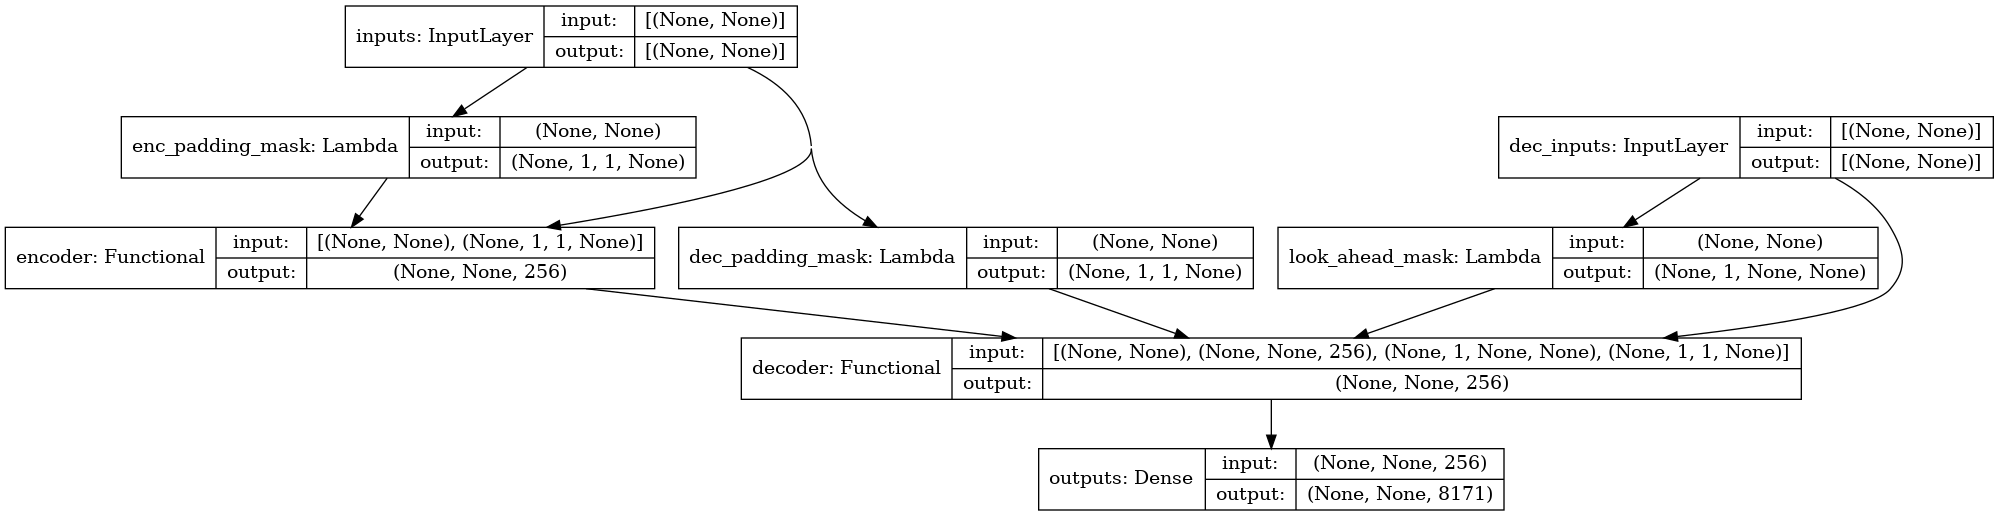

In [130]:
from tensorflow.keras.utils import plot_model
%matplotlib inline

plot_model(model, to_file='model.png')
plot_model(model, to_file='model_shapes.png', show_shapes=True)

## 기본모델 learning curve 시각화
- 모델의 loss가 안정적으로 줄어드는 것을 확인 할 수 있었다.

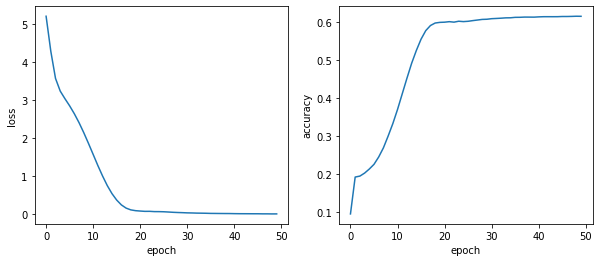

In [131]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(model.history.history["loss"])
plt.xlabel("epoch")
plt.ylabel("loss")

plt.subplot(1,2,2)
plt.plot(model.history.history["accuracy"])
plt.xlabel("epoch")
plt.ylabel("accuracy")

plt.show()

### 기본모델 대화 테스트

In [173]:
test_sentences=["피곤하다",
               "오늘 뭐 먹지?",
               "1년을 사귀었는데 헤어졌어",
               "남자친구가 연락이 없어",
               "짝사랑 중이야",
               "회사가기 싫어",
               "여자친구랑 놀러갈꺼야",
               "아메리카노 마시고 싶다",
               "좋아하는 사람이 생겼어",
               "고백할까?"]
test_output=[sentence_generation(i,model) for i in test_sentences]

입력 : 피곤하다
출력 : 혼자가 아니에요 .
------------------------------------------------------------
입력 : 오늘 뭐 먹지?
출력 : 색다른걸 드셔보세요 .
------------------------------------------------------------
입력 : 1년을 사귀었는데 헤어졌어
출력 : 대화를 하면서 속도를 맞춰보세요 .
------------------------------------------------------------
입력 : 남자친구가 연락이 없어
출력 : 먼저 연락을 해보세요 .
------------------------------------------------------------
입력 : 짝사랑 중이야
출력 : 진정으로 사랑한다면 그 사람도 당신의 사랑을 알아볼거예요 .
------------------------------------------------------------
입력 : 회사가기 싫어
출력 : 회사는 친구 사귀는 곳이 아니에요 .
------------------------------------------------------------
입력 : 여자친구랑 놀러갈꺼야
출력 : 행운을 빌어요 .
------------------------------------------------------------
입력 : 아메리카노 마시고 싶다
출력 : 마시면 좋죠 .
------------------------------------------------------------
입력 : 좋아하는 사람이 생겼어
출력 : 내 집 마련 축하드려요 .
------------------------------------------------------------
입력 : 고백할까?
출력 : 선물을 주면서 솔직하고 당당하게 고백해보세요 .
------------------------------------------------------------


In [174]:
test_df=pd.DataFrame(test_sentences,columns=["Q"])

test_df["pred1_A"]=test_output

In [175]:
test_df

,Q,pred1_A
0,피곤하다,혼자가 아니에요 .
1,오늘 뭐 먹지?,색다른걸 드셔보세요 .
2,1년을 사귀었는데 헤어졌어,대화를 하면서 속도를 맞춰보세요 .
3,남자친구가 연락이 없어,먼저 연락을 해보세요 .
4,짝사랑 중이야,진정으로 사랑한다면 그 사람도 당신의 사랑을 알아볼거예요 .
5,회사가기 싫어,회사는 친구 사귀는 곳이 아니에요 .
6,여자친구랑 놀러갈꺼야,행운을 빌어요 .
7,아메리카노 마시고 싶다,마시면 좋죠 .
8,좋아하는 사람이 생겼어,내 집 마련 축하드려요 .
9,고백할까?,선물을 주면서 솔직하고 당당하게 고백해보세요 .


## 다양한 테스트를 하기 위해서 데이터셋 만드는 함수

In [135]:
from tensorflow.keras.utils import plot_model
%matplotlib inline

def make_dataset(input_, output_,MAX_LENGTH = 11,BATCH_SIZE = 64,BUFFER_SIZE = 12000):
    # 샘플의 최대 허용 길이 또는 패딩 후의 최종 길이    
    print("최대문장 길이:",MAX_LENGTH)

    questions, answers=filter_(input_, output_)
    print('단어장의 크기 :',(VOCAB_SIZE))
    print('필터링 후의 질문 샘플 개수: {}'.format(len(questions)))
    print('필터링 후의 답변 샘플 개수: {}'.format(len(answers)))

    # 디코더는 이전의 target을 다음의 input으로 사용합니다.
    # 이에 따라 outputs에서는 START_TOKEN을 제거하겠습니다.
    dataset = tf.data.Dataset.from_tensor_slices((
        {'inputs': questions,'dec_inputs': answers[:, :-1]},{'outputs': answers[:, 1:]},))
    
    dataset = dataset.cache()
    dataset = dataset.shuffle(BUFFER_SIZE)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

    return dataset

# 모델 학습
def model_train(dataset, hyper_param):
    tf.keras.backend.clear_session()
    # 하이퍼파라미터
    NUM_LAYERS = hyper_param["NUM_LAYERS"]  # 인코더와 디코더의 층의 개수
    D_MODEL = hyper_param["D_MODEL"]     # 인코더와 디코더 내부의 입, 출력의 고정 차원
    NUM_HEADS = hyper_param["NUM_HEADS"]   # 멀티 헤드 어텐션에서의 헤드 수 
    UNITS =  hyper_param["UNITS"]      # 피드 포워드 신경망의 은닉층의 크기
    DROPOUT =  hyper_param["DROPOUT"]    # 드롭아웃의 비율
    EPOCHS =  hyper_param["EPOCHS"]
    
    model = transformer(
        vocab_size=VOCAB_SIZE,
        num_layers=NUM_LAYERS,
        units=UNITS,
        d_model=D_MODEL,
        num_heads=NUM_HEADS,
        dropout=DROPOUT)
    #model.summary()
    
    # 커스텀한 learning rate 스케쥴러
    learning_rate = CustomSchedule(D_MODEL)
    
    optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)
    model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])
    # 학습
    model.fit(dataset, epochs=EPOCHS, verbose=0)
    return model

## 학습곡선 시각화
def draw_training_history(model_name, model):
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.plot(model.history.history["loss"])
    plt.title("loss(%s)"%model_name)
    plt.xlabel("epoch")
    plt.ylabel("loss")
    
    plt.subplot(1,2,2)
    plt.plot(model.history.history["accuracy"])
    plt.xlabel("epoch")
    plt.ylabel("accuracy")
    plt.title("accuracy(%s)"%model_name)
    plt.show()

## 모델 2-1: 인코더 디코더의 블록 개수 4개

최대문장 길이: 11
단어장의 크기 : 8171
필터링 후의 질문 샘플 개수: 10165
필터링 후의 답변 샘플 개수: 10165


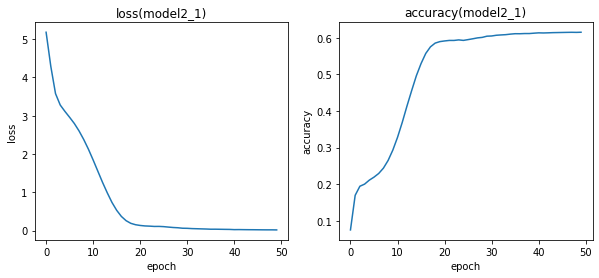

time : 265.3123707771301


In [136]:
start=time.time()
hyper_param2_1={"NUM_LAYERS":2*2, # 인코더와 디코더의 층의 개수
             "D_MODEL": 256, # 인코더와 디코더 내부의 입, 출력의 고정 차원
             "NUM_HEADS":8, # 멀티 헤드 어텐션에서의 헤드 수 
             "UNITS":512, # 피드 포워드 신경망의 은닉층의 크기
             "DROPOUT":0.1, # 드롭아웃의 비율
             "EPOCHS":50} # epoch

model2_1 = model_train(make_dataset(df["Q_enc"],df["A_enc"],MAX_LENGTH = 11,BATCH_SIZE = 64,BUFFER_SIZE = 12000), 
                     hyper_param=hyper_param2_1)

draw_training_history("model2_1",model2_1)

period=time.time() - start

model_time["model2_1"]=period

print("time :", period)

In [176]:
test_output2_1=[sentence_generation(i,model2_1) for i in test_sentences]
test_df["pred2_1_A"]=test_output2_1

입력 : 피곤하다
출력 : 지금처럼 참지 말고 표현하세요 .
------------------------------------------------------------
입력 : 오늘 뭐 먹지?
출력 : 맛있는 거 드세요 .
------------------------------------------------------------
입력 : 1년을 사귀었는데 헤어졌어
출력 : 더 힘들지 않았으면 좋겠어요 .
------------------------------------------------------------
입력 : 남자친구가 연락이 없어
출력 : 먼저 연락을 해보세요 .
------------------------------------------------------------
입력 : 짝사랑 중이야
출력 : 진정으로 사랑한다면 그 사람을 사랑한다면 그 사람을 찾아보세요 .
------------------------------------------------------------
입력 : 회사가기 싫어
출력 : 우울한 생각들을 멈추세요 .
------------------------------------------------------------
입력 : 여자친구랑 놀러갈꺼야
출력 : 연인과 함께면 어디든 좋아요 .
------------------------------------------------------------
입력 : 아메리카노 마시고 싶다
출력 : 마시면 좋죠 .
------------------------------------------------------------
입력 : 좋아하는 사람이 생겼어
출력 : 축하해요 .
------------------------------------------------------------
입력 : 고백할까?
출력 : 솔직한 마음으로 다가가는 거죠 .
------------------------------------------------------------


## 모델 2-2: Encoder & Decoder block 6개

최대문장 길이: 11
단어장의 크기 : 8171
필터링 후의 질문 샘플 개수: 10165
필터링 후의 답변 샘플 개수: 10165


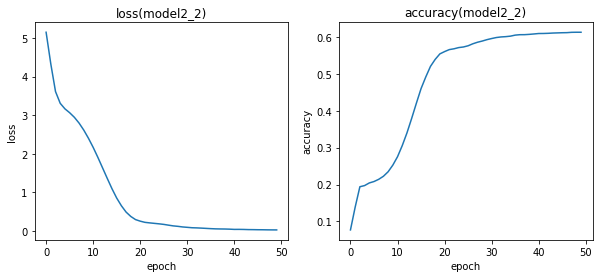

time : 349.257075548172


In [138]:
hyper_param2_2={"NUM_LAYERS":2*3, # 인코더와 디코더의 층의 개수
             "D_MODEL": 256, # 인코더와 디코더 내부의 입, 출력의 고정 차원
             "NUM_HEADS":8, # 멀티 헤드 어텐션에서의 헤드 수 
             "UNITS":512, # 피드 포워드 신경망의 은닉층의 크기
             "DROPOUT":0.1, # 드롭아웃의 비율
             "EPOCHS":50} # epoch

start=time.time()
model2_2 = model_train(make_dataset(df["Q_enc"],df["A_enc"],MAX_LENGTH = 11,BATCH_SIZE = 64,BUFFER_SIZE = 12000), 
                     hyper_param=hyper_param2_2)

draw_training_history("model2_2",model2_2)

period=time.time() - start

model_time["model2_2"]=period

print("time :", period)

In [177]:
test_output2_2=[sentence_generation(i,model2_2) for i in test_sentences]
test_df["pred_2_2 A"]=test_output2_2

입력 : 피곤하다
출력 : 신아닌가요 .
------------------------------------------------------------
입력 : 오늘 뭐 먹지?
출력 : 색다른걸 드셔보세요 .
------------------------------------------------------------
입력 : 1년을 사귀었는데 헤어졌어
출력 : 아직도 힘들었겠어요 .
------------------------------------------------------------
입력 : 남자친구가 연락이 없어
출력 : 먼저 연락을 해보세요 .
------------------------------------------------------------
입력 : 짝사랑 중이야
출력 : 진정으로 사랑한다면 그 사람도 좋아하는 사랑을 알아볼거예요 .
------------------------------------------------------------
입력 : 회사가기 싫어
출력 : 우울한 이유에 대해 생각해보세요 .
------------------------------------------------------------
입력 : 여자친구랑 놀러갈꺼야
출력 : 연인과 함께고 있죠 .
------------------------------------------------------------
입력 : 아메리카노 마시고 싶다
출력 : 마시면 좋죠 .
------------------------------------------------------------
입력 : 좋아하는 사람이 생겼어
출력 : 충분히 아름다워요 .
------------------------------------------------------------
입력 : 고백할까?
출력 : 선물을 주면서 솔직하고 당당하게 고백해보세요 .
------------------------------------------------------------


## 모델 2-3: Encoder & Decoder block 8개

최대문장 길이: 11
단어장의 크기 : 8171
필터링 후의 질문 샘플 개수: 10165
필터링 후의 답변 샘플 개수: 10165
time : 437.9880545139313


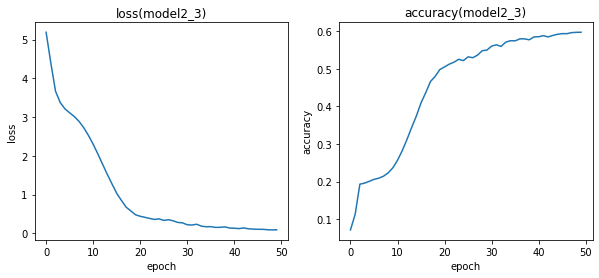

In [140]:
start=time.time()
hyper_param2_3={"NUM_LAYERS":2*4, # 인코더와 디코더의 층의 개수
             "D_MODEL": 256, # 인코더와 디코더 내부의 입, 출력의 고정 차원
             "NUM_HEADS":8, # 멀티 헤드 어텐션에서의 헤드 수 
             "UNITS":512, # 피드 포워드 신경망의 은닉층의 크기
             "DROPOUT":0.1, # 드롭아웃의 비율
             "EPOCHS":50} # epoch

model2_3 = model_train(make_dataset(df["Q_enc"],df["A_enc"],MAX_LENGTH = 11,BATCH_SIZE = 64,BUFFER_SIZE = 12000), 
                     hyper_param=hyper_param2_3)


period=time.time() - start

model_time["model2_3"]=period

print("time :", period)

draw_training_history("model2_3",model2_3)

In [178]:
test_output2_3=[sentence_generation(i,model2_3) for i in test_sentences]
test_df["pred_2_3 A"]=test_output2_3

입력 : 피곤하다
출력 : 조급해할 거예요 .
------------------------------------------------------------
입력 : 오늘 뭐 먹지?
출력 : 색다른걸 드세요 .
------------------------------------------------------------
입력 : 1년을 사귀었는데 헤어졌어
출력 : 먼저 양말고 싶은 다가가야죠 .
------------------------------------------------------------
입력 : 남자친구가 연락이 없어
출력 : 먼저 연락을 해보세요 .
------------------------------------------------------------
입력 : 짝사랑 중이야
출력 : 진정으로 사랑한다면 그 동안 행복하길 거예요 .
------------------------------------------------------------
입력 : 회사가기 싫어
출력 : 회사는 친구 사귀는 곳이 아니에요 .
------------------------------------------------------------
입력 : 여자친구랑 놀러갈꺼야
출력 : 혼자도 좋아요 .
------------------------------------------------------------
입력 : 아메리카노 마시고 싶다
출력 : 마시면 좋죠 .
------------------------------------------------------------
입력 : 좋아하는 사람이 생겼어
출력 : 축하해요 .
------------------------------------------------------------
입력 : 고백할까?
출력 : 선물을 주면서 솔직하고 당당하게 고백해보세요 .
------------------------------------------------------------


## 모델 3-1: NUM_HEADS:16
- 가장 기본모델의 대답이 적절한 답처럼 보여서 기본 모델인 2층을 선택하기로 했다.
- 멀티 헤드 어텐션의 헤드 개수를 지금 8개에서 2배 늘린 16개로 조정해서 돌려보기로 했다.

최대문장 길이: 11
단어장의 크기 : 8171
필터링 후의 질문 샘플 개수: 10165
필터링 후의 답변 샘플 개수: 10165
time : 186.32504081726074


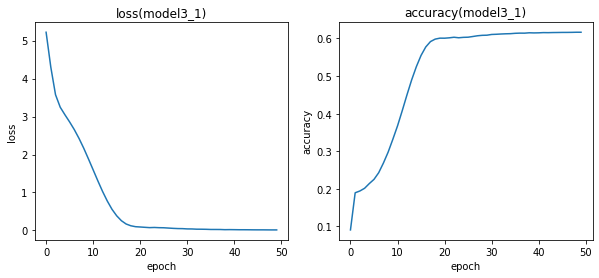

In [142]:
start=time.time()
hyper_param3_1={"NUM_LAYERS":2, # 인코더와 디코더의 층의 개수
             "D_MODEL": 256, # 인코더와 디코더 내부의 입, 출력의 고정 차원
             "NUM_HEADS":8*2, # 멀티 헤드 어텐션에서의 헤드 수 
             "UNITS":512, # 피드 포워드 신경망의 은닉층의 크기
             "DROPOUT":0.1, # 드롭아웃의 비율
             "EPOCHS":50} # epoch

model3_1 = model_train(make_dataset(df["Q_enc"],df["A_enc"],MAX_LENGTH = 11,BATCH_SIZE = 64,BUFFER_SIZE = 12000), 
                     hyper_param=hyper_param3_1)


period=time.time() - start

model_time["model3_1"]=period

print("time :", period)

draw_training_history("model3_1",model3_1)

In [179]:
test_output3_1=[sentence_generation(i,model3_1) for i in test_sentences]
test_df["pred_3_1 A"]=test_output3_1

입력 : 피곤하다
출력 : 매일매일 조금씩 더 똑똑해 질거예요 .
------------------------------------------------------------
입력 : 오늘 뭐 먹지?
출력 : 색다른걸 드셔보세요 .
------------------------------------------------------------
입력 : 1년을 사귀었는데 헤어졌어
출력 : 호감을 표시하고 더 생각해 보세요 .
------------------------------------------------------------
입력 : 남자친구가 연락이 없어
출력 : 먼저 연락을 해보세요 .
------------------------------------------------------------
입력 : 짝사랑 중이야
출력 : 진정으로 사랑한다면 그 누구도 당신의 사랑을 알아볼거예요 .
------------------------------------------------------------
입력 : 회사가기 싫어
출력 : 우울한 이유에 대해 생각해보세요 .
------------------------------------------------------------
입력 : 여자친구랑 놀러갈꺼야
출력 : 저랑 놀아요 .
------------------------------------------------------------
입력 : 아메리카노 마시고 싶다
출력 : 마시면 좋죠 .
------------------------------------------------------------
입력 : 좋아하는 사람이 생겼어
출력 : 마음이 내 마음 같지 않죠 .
------------------------------------------------------------
입력 : 고백할까?
출력 : 선물을 주면서 솔직하고 당당하게 고백해보세요 .
------------------------------------------------------------


## 모델 3-2: NUM_HEADS:32


최대문장 길이: 11
단어장의 크기 : 8171
필터링 후의 질문 샘플 개수: 10165
필터링 후의 답변 샘플 개수: 10165
time : 197.64991879463196


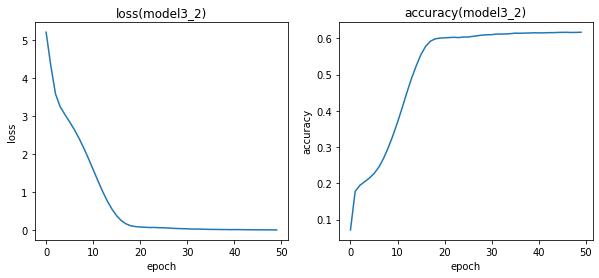

In [144]:
start=time.time()
hyper_param3_2={"NUM_LAYERS":2, # 인코더와 디코더의 층의 개수
             "D_MODEL": 256, # 인코더와 디코더 내부의 입, 출력의 고정 차원
             "NUM_HEADS":8*4, # 멀티 헤드 어텐션에서의 헤드 수 
             "UNITS":512, # 피드 포워드 신경망의 은닉층의 크기
             "DROPOUT":0.1, # 드롭아웃의 비율
             "EPOCHS":50} # epoch

model3_2 = model_train(make_dataset(df["Q_enc"],df["A_enc"],MAX_LENGTH = 11,BATCH_SIZE = 64,BUFFER_SIZE = 12000), 
                     hyper_param=hyper_param3_2)


period=time.time() - start

model_time["model3_2"]=period

print("time :", period)

draw_training_history("model3_2",model3_2)

In [180]:
test_output3_2=[sentence_generation(i,model3_2) for i in test_sentences]
test_df["pred_3_2 A"]=test_output3_2

입력 : 피곤하다
출력 : 혼자가 아니에요 .
------------------------------------------------------------
입력 : 오늘 뭐 먹지?
출력 : 색다른걸 드셔보세요 .
------------------------------------------------------------
입력 : 1년을 사귀었는데 헤어졌어
출력 : 직접 대화를 나눴길 바랍니다 .
------------------------------------------------------------
입력 : 남자친구가 연락이 없어
출력 : 먼저 연락을 해보세요 .
------------------------------------------------------------
입력 : 짝사랑 중이야
출력 : 진정으로 사랑한다면 그 사람도 당신의 사랑을 알아볼거예요 .
------------------------------------------------------------
입력 : 회사가기 싫어
출력 : 정열적인 사랑을 하고 있나봐요 .
------------------------------------------------------------
입력 : 여자친구랑 놀러갈꺼야
출력 : 연인과 함께면 어디든 좋아요 .
------------------------------------------------------------
입력 : 아메리카노 마시고 싶다
출력 : 마시면 좋죠 .
------------------------------------------------------------
입력 : 좋아하는 사람이 생겼어
출력 : 축하드려요 .
------------------------------------------------------------
입력 : 고백할까?
출력 : 선물을 주면서 솔직하고 당당하게 고백해보세요 .
------------------------------------------------------------


## 모델 3-3:  NUM_HEADS:48

최대문장 길이: 11
단어장의 크기 : 8171
필터링 후의 질문 샘플 개수: 10165
필터링 후의 답변 샘플 개수: 10165
time : 219.77049350738525


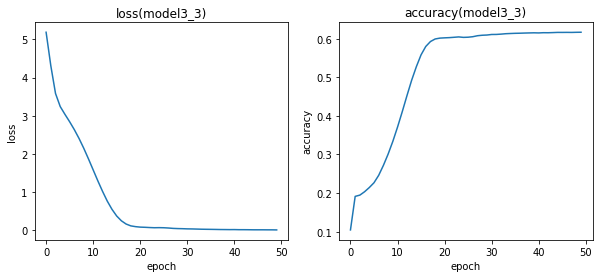

In [146]:
start=time.time()
hyper_param3_3={"NUM_LAYERS":2, # 인코더와 디코더의 층의 개수
             "D_MODEL": 256, # 인코더와 디코더 내부의 입, 출력의 고정 차원
             "NUM_HEADS":8*8, # 멀티 헤드 어텐션에서의 헤드 수 
             "UNITS":512, # 피드 포워드 신경망의 은닉층의 크기
             "DROPOUT":0.1, # 드롭아웃의 비율
             "EPOCHS":50} # epoch

model3_3 = model_train(make_dataset(df["Q_enc"],df["A_enc"],MAX_LENGTH = 11,BATCH_SIZE = 64,BUFFER_SIZE = 12000), 
                     hyper_param=hyper_param3_3)


period=time.time() - start

model_time["model3_3"]=period

print("time :", period)

draw_training_history("model3_3",model3_3)

In [181]:
test_output3_3=[sentence_generation(i,model3_3) for i in test_sentences]
test_df["pred_3_3 A"]=test_output3_3

입력 : 피곤하다
출력 : 다른 사람이 있는 거예요 .
------------------------------------------------------------
입력 : 오늘 뭐 먹지?
출력 : 색다른걸 드셔보세요 .
------------------------------------------------------------
입력 : 1년을 사귀었는데 헤어졌어
출력 : 더 오래 살고 나눴길 바랍니다 .
------------------------------------------------------------
입력 : 남자친구가 연락이 없어
출력 : 먼저 연락을 해보세요 .
------------------------------------------------------------
입력 : 짝사랑 중이야
출력 : 짝사랑은 시작과 끝을 자신이 결정할 수 있어요 .
------------------------------------------------------------
입력 : 회사가기 싫어
출력 : 다른 사람들이 원하는 내가 되는 건 어려워요 .
------------------------------------------------------------
입력 : 여자친구랑 놀러갈꺼야
출력 : 연인과 함께면 어디든 좋아요 .
------------------------------------------------------------
입력 : 아메리카노 마시고 싶다
출력 : 마시면 좋죠 .
------------------------------------------------------------
입력 : 좋아하는 사람이 생겼어
출력 : 어서 어서 충전 하세요 .
------------------------------------------------------------
입력 : 고백할까?
출력 : 선물을 주면서 솔직하고 당당하게 고백해보세요 .
------------------------------------------------------------


## 모델 4-1: Feed forward NN 은닉층 크기 1024

최대문장 길이: 11
단어장의 크기 : 8171
필터링 후의 질문 샘플 개수: 10165
필터링 후의 답변 샘플 개수: 10165
time : 141.5786681175232


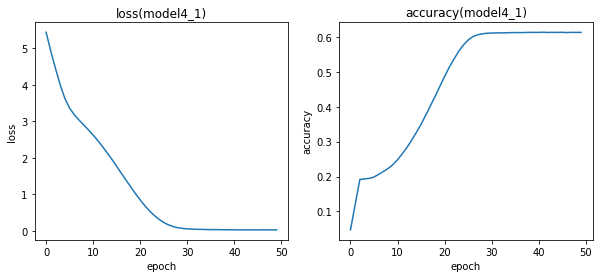

In [148]:
start=time.time()
hyper_param4_1={"NUM_LAYERS":2, # 인코더와 디코더의 층의 개수
             "D_MODEL": 256, # 인코더와 디코더 내부의 입, 출력의 고정 차원
             "NUM_HEADS":8, # 멀티 헤드 어텐션에서의 헤드 수 
             "UNITS":512*2, # 피드 포워드 신경망의 은닉층의 크기
             "DROPOUT":0.1, # 드롭아웃의 비율
             "EPOCHS":50} # epoch

model4_1 = model_train(make_dataset(df["Q_enc"],df["A_enc"],MAX_LENGTH = 11,BATCH_SIZE = 128,BUFFER_SIZE = 12000), 
                     hyper_param=hyper_param4_1)


period=time.time() - start

model_time["model4_1"]=period

print("time :", period)

draw_training_history("model4_1",model4_1)

In [182]:
test_output4_1=[sentence_generation(i,model4_1) for i in test_sentences]
test_df["pred_4_1 A"]=test_output4_1

입력 : 피곤하다
출력 : 혼자가 되는 건 없어요 .
------------------------------------------------------------
입력 : 오늘 뭐 먹지?
출력 : 색다른걸 드셔보세요 .
------------------------------------------------------------
입력 : 1년을 사귀었는데 헤어졌어
출력 : 더 후회하기 전에 사과하세요 .
------------------------------------------------------------
입력 : 남자친구가 연락이 없어
출력 : 먼저 연락을 해보세요 .
------------------------------------------------------------
입력 : 짝사랑 중이야
출력 : 진정으로 사랑한다면 그 사람도 있어요 .
------------------------------------------------------------
입력 : 회사가기 싫어
출력 : 우울한 이유에 대해 생각해보세요 .
------------------------------------------------------------
입력 : 여자친구랑 놀러갈꺼야
출력 : 커피향 좋겠어요 .
------------------------------------------------------------
입력 : 아메리카노 마시고 싶다
출력 : 마시면 좋죠 .
------------------------------------------------------------
입력 : 좋아하는 사람이 생겼어
출력 : 내 집 마련 축하드려요 .
------------------------------------------------------------
입력 : 고백할까?
출력 : 선물을 주면서 솔직하고 당당하게 고백해보세요 .
------------------------------------------------------------


## 모델 4-2: Feed forward NN 은닉층 크기 2048

최대문장 길이: 11
단어장의 크기 : 8171
필터링 후의 질문 샘플 개수: 10165
필터링 후의 답변 샘플 개수: 10165
time : 156.37944293022156


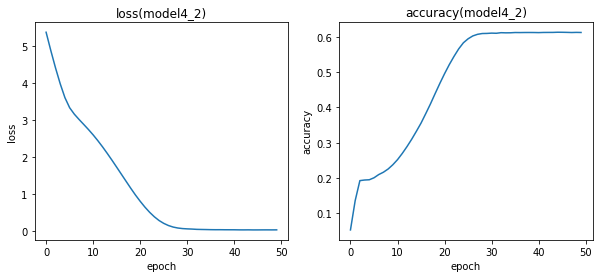

In [150]:
start=time.time()
hyper_param4_2={"NUM_LAYERS":2, # 인코더와 디코더의 층의 개수
             "D_MODEL": 256, # 인코더와 디코더 내부의 입, 출력의 고정 차원
             "NUM_HEADS":8, # 멀티 헤드 어텐션에서의 헤드 수 
             "UNITS":512*4, # 피드 포워드 신경망의 은닉층의 크기
             "DROPOUT":0.1, # 드롭아웃의 비율
             "EPOCHS":50} # epoch

model4_2 = model_train(make_dataset(df["Q_enc"],df["A_enc"],MAX_LENGTH = 11,BATCH_SIZE = 128,BUFFER_SIZE = 12000), 
                     hyper_param=hyper_param4_2)


period=time.time() - start

model_time["model4_2"]=period

print("time :", period)

draw_training_history("model4_2",model4_2)

In [183]:
test_output4_2=[sentence_generation(i,model4_2) for i in test_sentences]
test_df["pred_4_2 A"]=test_output4_2

입력 : 피곤하다
출력 : 많은 선택에 대해 좋아요 .
------------------------------------------------------------
입력 : 오늘 뭐 먹지?
출력 : 색다른걸 드셔보세요 .
------------------------------------------------------------
입력 : 1년을 사귀었는데 헤어졌어
출력 : 먼저 다가가고 알아가야죠 .
------------------------------------------------------------
입력 : 남자친구가 연락이 없어
출력 : 먼저 연락을 해보세요 .
------------------------------------------------------------
입력 : 짝사랑 중이야
출력 : 진정으로 사랑한다면 다시 시작해보세요 .
------------------------------------------------------------
입력 : 회사가기 싫어
출력 : 우울한 이유에 대해 생각해보세요 .
------------------------------------------------------------
입력 : 여자친구랑 놀러갈꺼야
출력 : 연인과 함께면 어디든 좋아요 .
------------------------------------------------------------
입력 : 아메리카노 마시고 싶다
출력 : 마시면 좋죠 .
------------------------------------------------------------
입력 : 좋아하는 사람이 생겼어
출력 : 충분히 아름다워요 .
------------------------------------------------------------
입력 : 고백할까?
출력 : 선물을 주면서 솔직하고 당당하게 고백해보세요 .
------------------------------------------------------------


## 모델 4-3: Feed forward NN 은닉층 크기 4098

최대문장 길이: 11
단어장의 크기 : 8171
필터링 후의 질문 샘플 개수: 10165
필터링 후의 답변 샘플 개수: 10165
time : 185.09678673744202


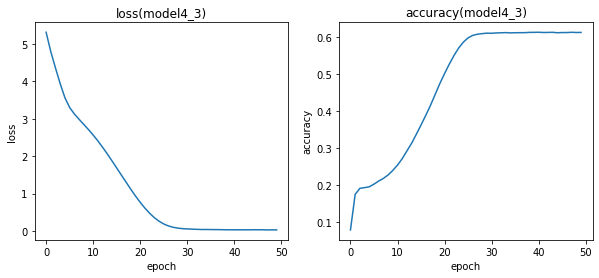

In [152]:
start=time.time()
hyper_param4_3={"NUM_LAYERS":2, # 인코더와 디코더의 층의 개수
             "D_MODEL": 256, # 인코더와 디코더 내부의 입, 출력의 고정 차원
             "NUM_HEADS":8, # 멀티 헤드 어텐션에서의 헤드 수 
             "UNITS":512*8, # 피드 포워드 신경망의 은닉층의 크기
             "DROPOUT":0.1, # 드롭아웃의 비율
             "EPOCHS":50} # epoch

model4_3 = model_train(make_dataset(df["Q_enc"],df["A_enc"],MAX_LENGTH = 11,BATCH_SIZE = 128,BUFFER_SIZE = 12000), 
                     hyper_param=hyper_param4_3)


period=time.time() - start

model_time["model4_3"]=period

print("time :", period)

draw_training_history("model4_3",model4_3)

In [184]:
test_output4_3=[sentence_generation(i,model4_3) for i in test_sentences]
test_df["pred_4_3 A"]=test_output4_3

입력 : 피곤하다
출력 : 한가지만 보면 몰라요 .
------------------------------------------------------------
입력 : 오늘 뭐 먹지?
출력 : 색다른걸 드셔보세요 .
------------------------------------------------------------
입력 : 1년을 사귀었는데 헤어졌어
출력 : 생각이 더 나죠 .
------------------------------------------------------------
입력 : 남자친구가 연락이 없어
출력 : 먼저 연락을 해보세요 .
------------------------------------------------------------
입력 : 짝사랑 중이야
출력 : 서로 더 많이 아세요 .
------------------------------------------------------------
입력 : 회사가기 싫어
출력 : 우울한 이유에서 그랬을까요 .
------------------------------------------------------------
입력 : 여자친구랑 놀러갈꺼야
출력 : 연인과 함께면 어디든 좋아요 .
------------------------------------------------------------
입력 : 아메리카노 마시고 싶다
출력 : 마시면 좋죠 .
------------------------------------------------------------
입력 : 좋아하는 사람이 생겼어
출력 : 마음이 복잡하겠어요 .
------------------------------------------------------------
입력 : 고백할까?
출력 : 그 선물을 주면서 솔직하고 당당하게 고백해보세요 .
------------------------------------------------------------


## 모델 5:

최대문장 길이: 11
단어장의 크기 : 8171
필터링 후의 질문 샘플 개수: 10165
필터링 후의 답변 샘플 개수: 10165
time : 401.22008419036865


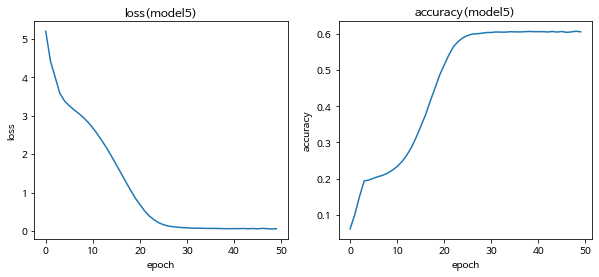

In [210]:
start=time.time()
hyper_param5={"NUM_LAYERS":6, # 인코더와 디코더의 층의 개수
             "D_MODEL": 256*2, # 인코더와 디코더 내부의 입, 출력의 고정 차원
             "NUM_HEADS":8*2, # 멀티 헤드 어텐션에서의 헤드 수 
             "UNITS":512, # 피드 포워드 신경망의 은닉층의 크기
             "DROPOUT":0.1, # 드롭아웃의 비율
             "EPOCHS":50} # epoch

model5 = model_train(make_dataset(df["Q_enc"],df["A_enc"],MAX_LENGTH = 11,BATCH_SIZE = 128,BUFFER_SIZE = 12000), 
                     hyper_param=hyper_param5)


period=time.time() - start

model_time["model5"]=period

print("time :", period)

draw_training_history("model5",model5)

In [211]:
test_output5=[sentence_generation(i,model5) for i in test_sentences]
test_df["pred_5 A"]=test_output5

입력 : 피곤하다
출력 : 마음 고생 많았어요 .
------------------------------------------------------------
입력 : 오늘 뭐 먹지?
출력 : 색다른걸 드셔보세요 .
------------------------------------------------------------
입력 : 1년을 사귀었는데 헤어졌어
출력 : 남자사람친구 , 여자사람친구 하세요 .
------------------------------------------------------------
입력 : 남자친구가 연락이 없어
출력 : 먼저 연락을 해보세요 .
------------------------------------------------------------
입력 : 짝사랑 중이야
출력 : 진정으로 사랑한다면 사랑을 알아볼거예요 .
------------------------------------------------------------
입력 : 회사가기 싫어
출력 : 솔직한 대화를 나눠보세요 .
------------------------------------------------------------
입력 : 여자친구랑 놀러갈꺼야
출력 : 연인과 함께면 어디든 좋아요 .
------------------------------------------------------------
입력 : 아메리카노 마시고 싶다
출력 : 마시면 좋죠 .
------------------------------------------------------------
입력 : 좋아하는 사람이 생겼어
출력 : 충분히 아름다워요 .
------------------------------------------------------------
입력 : 고백할까?
출력 : 솔직한 나이가 솔직하고 고백해보세요 .
------------------------------------------------------------


## 모델 5-2:

최대문장 길이: 11
단어장의 크기 : 8171
필터링 후의 질문 샘플 개수: 10165
필터링 후의 답변 샘플 개수: 10165
time : 971.9284300804138


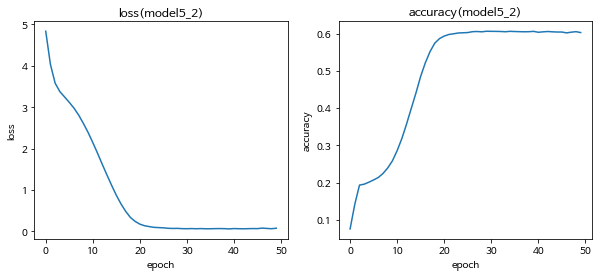

In [221]:
start=time.time()
hyper_param5_2={"NUM_LAYERS":6, # 인코더와 디코더의 층의 개수
             "D_MODEL": 256*4, # 인코더와 디코더 내부의 입, 출력의 고정 차원
             "NUM_HEADS":8*4, # 멀티 헤드 어텐션에서의 헤드 수 
             "UNITS":512, # 피드 포워드 신경망의 은닉층의 크기
             "DROPOUT":0.1, # 드롭아웃의 비율
             "EPOCHS":50} # epoch

model5_2 = model_train(make_dataset(df["Q_enc"],df["A_enc"],MAX_LENGTH = 11,BATCH_SIZE = 128,BUFFER_SIZE = 12000), 
                     hyper_param=hyper_param5_2)


period=time.time() - start

model_time["model5_2"]=period

print("time :", period)

draw_training_history("model5_2",model5_2)

In [222]:
test_output5_2=[sentence_generation(i,model5_2) for i in test_sentences]
test_df["pred_5_2 A"]=test_output5_2

입력 : 피곤하다
출력 : 너무 자책하지 마세요 .
------------------------------------------------------------
입력 : 오늘 뭐 먹지?
출력 : 색다른걸 드셔보세요 .
------------------------------------------------------------
입력 : 1년을 사귀었는데 헤어졌어
출력 : 시간을 기도 합니다 .
------------------------------------------------------------
입력 : 남자친구가 연락이 없어
출력 : 먼저 연락을 해보세요 .
------------------------------------------------------------
입력 : 짝사랑 중이야
출력 : 행복하길 당신의 사랑을 당신의 사랑을 당신의 사랑을 당신의 사랑을 당신의 사랑을 
------------------------------------------------------------
입력 : 회사가기 싫어
출력 : 우울한 이유고 같이 가보세요 .
------------------------------------------------------------
입력 : 여자친구랑 놀러갈꺼야
출력 : 연인과 좋아요 .
------------------------------------------------------------
입력 : 아메리카노 마시고 싶다
출력 : 마시면 좋죠 .
------------------------------------------------------------
입력 : 좋아하는 사람이 생겼어
출력 : 충분히 아름다워요 .
------------------------------------------------------------
입력 : 고백할까?
출력 : 솔직한 마음을 전해보세요 .
------------------------------------------------------------


## 모델 5-3:

최대문장 길이: 11
단어장의 크기 : 8171
필터링 후의 질문 샘플 개수: 10165
필터링 후의 답변 샘플 개수: 10165
time : 1758.4464619159698


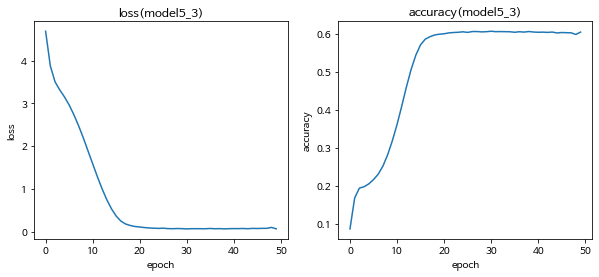

In [223]:
start=time.time()
hyper_param5_3={"NUM_LAYERS":6, # 인코더와 디코더의 층의 개수
             "D_MODEL": 256*6, # 인코더와 디코더 내부의 입, 출력의 고정 차원
             "NUM_HEADS":8*6, # 멀티 헤드 어텐션에서의 헤드 수 
             "UNITS":512, # 피드 포워드 신경망의 은닉층의 크기
             "DROPOUT":0.1, # 드롭아웃의 비율
             "EPOCHS":50} # epoch

model5_3 = model_train(make_dataset(df["Q_enc"],df["A_enc"],MAX_LENGTH = 11,BATCH_SIZE = 128,BUFFER_SIZE = 12000), 
                     hyper_param=hyper_param5_3)


period=time.time() - start

model_time["model5_3"]=period

print("time :", period)

draw_training_history("model5_3",model5_3)

In [224]:
test_output5_3=[sentence_generation(i,model5_3) for i in test_sentences]
test_df["pred_5_3 A"]=test_output5_3

입력 : 피곤하다
출력 : 모든 일은 예요 .
------------------------------------------------------------
입력 : 오늘 뭐 먹지?
출력 : 색다른걸 드셔보세요 .
------------------------------------------------------------
입력 : 1년을 사귀었는데 헤어졌어
출력 : 더 좋은 사람 많아요 .
------------------------------------------------------------
입력 : 남자친구가 연락이 없어
출력 : 먼저 연락을 해보세요 .
------------------------------------------------------------
입력 : 짝사랑 중이야
출력 : 직접 는 것도 자신이 결정할 수 있어요 .
------------------------------------------------------------
입력 : 회사가기 싫어
출력 : 부모님라면 먹고 싶어요 .
------------------------------------------------------------
입력 : 여자친구랑 놀러갈꺼야
출력 : 연인과 함께면 어디든 좋아요 .
------------------------------------------------------------
입력 : 아메리카노 마시고 싶다
출력 : 마시면 좋죠 .
------------------------------------------------------------
입력 : 좋아하는 사람이 생겼어
출력 : 충분히 아름다워요 .
------------------------------------------------------------
입력 : 고백할까?
출력 : 선물을 주면서 솔직하고 당당하게 고백해보세요 .
------------------------------------------------------------


## 전체 결과물

In [242]:
test_df.shape

(10, 14)

In [241]:
test_df

,Q,pred1_A,pred2_1_A,pred_2_2 A,pred_2_3 A,pred_3_1 A,pred_3_2 A,pred_3_3 A,pred_4_1 A,pred_4_2 A,pred_4_3 A,pred_5 A,pred_5_2 A,pred_5_3 A
0,피곤하다,혼자가 아니에요 .,지금처럼 참지 말고 표현하세요 .,신아닌가요 .,조급해할 거예요 .,매일매일 조금씩 더 똑똑해 질거예요 .,혼자가 아니에요 .,다른 사람이 있는 거예요 .,혼자가 되는 건 없어요 .,많은 선택에 대해 좋아요 .,한가지만 보면 몰라요 .,마음 고생 많았어요 .,너무 자책하지 마세요 .,모든 일은 예요 .
1,오늘 뭐 먹지?,색다른걸 드셔보세요 .,맛있는 거 드세요 .,색다른걸 드셔보세요 .,색다른걸 드세요 .,색다른걸 드셔보세요 .,색다른걸 드셔보세요 .,색다른걸 드셔보세요 .,색다른걸 드셔보세요 .,색다른걸 드셔보세요 .,색다른걸 드셔보세요 .,색다른걸 드셔보세요 .,색다른걸 드셔보세요 .,색다른걸 드셔보세요 .
2,1년을 사귀었는데 헤어졌어,대화를 하면서 속도를 맞춰보세요 .,더 힘들지 않았으면 좋겠어요 .,아직도 힘들었겠어요 .,먼저 양말고 싶은 다가가야죠 .,호감을 표시하고 더 생각해 보세요 .,직접 대화를 나눴길 바랍니다 .,더 오래 살고 나눴길 바랍니다 .,더 후회하기 전에 사과하세요 .,먼저 다가가고 알아가야죠 .,생각이 더 나죠 .,"남자사람친구 , 여자사람친구 하세요 .",시간을 기도 합니다 .,더 좋은 사람 많아요 .
3,남자친구가 연락이 없어,먼저 연락을 해보세요 .,먼저 연락을 해보세요 .,먼저 연락을 해보세요 .,먼저 연락을 해보세요 .,먼저 연락을 해보세요 .,먼저 연락을 해보세요 .,먼저 연락을 해보세요 .,먼저 연락을 해보세요 .,먼저 연락을 해보세요 .,먼저 연락을 해보세요 .,먼저 연락을 해보세요 .,먼저 연락을 해보세요 .,먼저 연락을 해보세요 .
4,짝사랑 중이야,진정으로 사랑한다면 그 사람도 당신의 사랑을 알아볼거예요 .,진정으로 사랑한다면 그 사람을 사랑한다면 그 사람을 찾아보세요 .,진정으로 사랑한다면 그 사람도 좋아하는 사랑을 알아볼거예요 .,진정으로 사랑한다면 그 동안 행복하길 거예요 .,진정으로 사랑한다면 그 누구도 당신의 사랑을 알아볼거예요 .,진정으로 사랑한다면 그 사람도 당신의 사랑을 알아볼거예요 .,짝사랑은 시작과 끝을 자신이 결정할 수 있어요 .,진정으로 사랑한다면 그 사람도 있어요 .,진정으로 사랑한다면 다시 시작해보세요 .,서로 더 많이 아세요 .,진정으로 사랑한다면 사랑을 알아볼거예요 .,행복하길 당신의 사랑을 당신의 사랑을 당신의 사랑을 당신의 사랑을 당신의 사랑을,직접 는 것도 자신이 결정할 수 있어요 .
5,회사가기 싫어,회사는 친구 사귀는 곳이 아니에요 .,우울한 생각들을 멈추세요 .,우울한 이유에 대해 생각해보세요 .,회사는 친구 사귀는 곳이 아니에요 .,우울한 이유에 대해 생각해보세요 .,정열적인 사랑을 하고 있나봐요 .,다른 사람들이 원하는 내가 되는 건 어려워요 .,우울한 이유에 대해 생각해보세요 .,우울한 이유에 대해 생각해보세요 .,우울한 이유에서 그랬을까요 .,솔직한 대화를 나눠보세요 .,우울한 이유고 같이 가보세요 .,부모님라면 먹고 싶어요 .
6,여자친구랑 놀러갈꺼야,행운을 빌어요 .,연인과 함께면 어디든 좋아요 .,연인과 함께고 있죠 .,혼자도 좋아요 .,저랑 놀아요 .,연인과 함께면 어디든 좋아요 .,연인과 함께면 어디든 좋아요 .,커피향 좋겠어요 .,연인과 함께면 어디든 좋아요 .,연인과 함께면 어디든 좋아요 .,연인과 함께면 어디든 좋아요 .,연인과 좋아요 .,연인과 함께면 어디든 좋아요 .
7,아메리카노 마시고 싶다,마시면 좋죠 .,마시면 좋죠 .,마시면 좋죠 .,마시면 좋죠 .,마시면 좋죠 .,마시면 좋죠 .,마시면 좋죠 .,마시면 좋죠 .,마시면 좋죠 .,마시면 좋죠 .,마시면 좋죠 .,마시면 좋죠 .,마시면 좋죠 .
8,좋아하는 사람이 생겼어,내 집 마련 축하드려요 .,축하해요 .,충분히 아름다워요 .,축하해요 .,마음이 내 마음 같지 않죠 .,축하드려요 .,어서 어서 충전 하세요 .,내 집 마련 축하드려요 .,충분히 아름다워요 .,마음이 복잡하겠어요 .,충분히 아름다워요 .,충분히 아름다워요 .,충분히 아름다워요 .
9,고백할까?,선물을 주면서 솔직하고 당당하게 고백해보세요 .,솔직한 마음으로 다가가는 거죠 .,선물을 주면서 솔직하고 당당하게 고백해보세요 .,선물을 주면서 솔직하고 당당하게 고백해보세요 .,선물을 주면서 솔직하고 당당하게 고백해보세요 .,선물을 주면서 솔직하고 당당하게 고백해보세요 .,선물을 주면서 솔직하고 당당하게 고백해보세요 .,선물을 주면서 솔직하고 당당하게 고백해보세요 .,선물을 주면서 솔직하고 당당하게 고백해보세요 .,그 선물을 주면서 솔직하고 당당하게 고백해보세요 .,솔직한 나이가 솔직하고 고백해보세요 .,솔직한 마음을 전해보세요 .,선물을 주면서 솔직하고 당당하게 고백해보세요 .


In [225]:
model_time

{'model1': 188.46756267547607,
 'model2_1': 265.3123707771301,
 'model2_2': 349.257075548172,
 'model2_3': 437.9880545139313,
 'model3_1': 186.32504081726074,
 'model3_2': 197.64991879463196,
 'model3_3': 219.77049350738525,
 'model4_1': 141.5786681175232,
 'model4_2': 156.37944293022156,
 'model4_3': 185.09678673744202,
 'model5': 401.22008419036865,
 'model5_2': 971.9284300804138,
 'model5_3': 1758.4464619159698}

## 테스트 결과
 기본 모델을 튜닝해서 14개의 모델을 돌려보았다. 14개 챗봇 하나당 10개의 질문을 했고, 각각 답변이 나왔고 그 중에서 가장 무난한 답변을 한 챗봇은 
 - model2_1(기본 모델에 NUM_LAYERS:4)/ 예측 답변pred2_1_A
 - model5(NUM_LAYERS:6,D_MODEL: 512, NUM_HEADS: 16)/ 예측 답변 pred_5A 


 대단하게 기발한 답변은 없지만, 다른 챗봇처럼 답변에 아주 크게 벗어나지는 않은 답을 한다. 또한 '피곤하다'는 말에 무난하게 위로가 되는 말을 하기도 한다.
 이렇게 적당하게 괜찮은 대답을 출력하지만 아래와 같이 몇가지 문제가 있기도 했다.

In [240]:
test_df[["Q","pred2_1_A","pred_5 A"]]

,Q,pred2_1_A,pred_5 A
0,피곤하다,지금처럼 참지 말고 표현하세요 .,마음 고생 많았어요 .
1,오늘 뭐 먹지?,맛있는 거 드세요 .,색다른걸 드셔보세요 .
2,1년을 사귀었는데 헤어졌어,더 힘들지 않았으면 좋겠어요 .,"남자사람친구 , 여자사람친구 하세요 ."
3,남자친구가 연락이 없어,먼저 연락을 해보세요 .,먼저 연락을 해보세요 .
4,짝사랑 중이야,진정으로 사랑한다면 그 사람을 사랑한다면 그 사람을 찾아보세요 .,진정으로 사랑한다면 사랑을 알아볼거예요 .
5,회사가기 싫어,우울한 생각들을 멈추세요 .,솔직한 대화를 나눠보세요 .
6,여자친구랑 놀러갈꺼야,연인과 함께면 어디든 좋아요 .,연인과 함께면 어디든 좋아요 .
7,아메리카노 마시고 싶다,마시면 좋죠 .,마시면 좋죠 .
8,좋아하는 사람이 생겼어,축하해요 .,충분히 아름다워요 .
9,고백할까?,솔직한 마음으로 다가가는 거죠 .,솔직한 나이가 솔직하고 고백해보세요 .


### 문제1: 어떤 모델도 비슷한 답변을 내놓는 질문

In [192]:
df.loc[df["Q"].str.contains("뭐 먹지")]

,Q,A,label,Q_words,A_words,nQ,nA,Q_enc,A_enc
1807,뭐 먹지 ?,색다른걸 드셔보세요 .,0,"[뭐, 먹지, ?]","[색다른걸, 드셔보세요, .]",3,4,"[8169, 154, 4371, 2, 8170]","[8169, 1543, 7533, 2657, 1, 8170]"
3867,입맛없는데 뭐 먹지,신경 쓸 일이 있나봐요 .,0,"[입맛없는데, 뭐, 먹지]","[신경, 쓸, 일이, 있나봐요, .]",5,5,"[8169, 818, 7283, 128, 154, 4371, 8170]","[8169, 954, 2924, 131, 356, 1, 8170]"
4036,저녁 뭐 먹지 ?,맛있는 거 드세요 .,0,"[저녁, 뭐, 먹지, ?]","[맛있는, 거, 드세요, .]",4,4,"[8169, 2846, 154, 4371, 2, 8170]","[8169, 835, 8, 122, 1, 8170]"


In [193]:
df.loc[df["Q"].str.contains("아메리카노")]

,Q,A,label,Q_words,A_words,nQ,nA,Q_enc,A_enc
2849,아메리카노 잔,마시면 좋죠 .,0,"[아메리카노, 잔]","[마시면, 좋죠, .]",6,3,"[8169, 134, 5389, 997, 839, 7945, 1298, 8170]","[8169, 3037, 129, 1, 8170]"


- 하이퍼파라미터를 바꿔가면서 14개의 모델을 돌리면서 유독 "아메리카노 마시고 싶다", "오늘 뭐 먹지" 같은 질문에 대해서는 똑같은 대답을 내놓았다. 
- 혹시나 싶어서 데이터를 찾아보니까 학습 데이터셋에 동일한 문답이 있어서 그대로 답변을 하는 것을 알수 있었다. 우연히도 학습데이터와 똑같은 질문이 들어와서 답을 그대로 내놓았거나, 교사강요(teacher forcing)으로 인해 생겨나는 현상이 아닐까 생각을 해보았다
- 해결방법으로 위와 같이 똑같은 대답을 출력하는 질문들에 대해서 데이터를 추가하면 어떨까 싶다.  
    예를들어 데이터셋에 "아침에 아메리카노를 안 마시면 정신을 못 차리겠어" "카페인 중독이시군요" 라던지 아메리카노에 대한 데이터 셋을 추가하면 어떨까 싶다.

### 문제2: 가끔 일상 대답에 연애관련 이야기로 답한다.
- "회사가기 싫어"라는 질문에 대부분 괜찮은 질문을 했다. pred_3_2 A(model3_2)의 경우 "정열적인 사랑을 하고 있나봐요"라고 전혀 생뚱맞은 이야기를 하는 것을 볼수 있었다. 
- 아마도 일상적인 대화 데이터와 연애 데이터셋이 섞여있다보니까 일상적인 이야기에 느닷없이 사랑이야기로 응대를 하는 것처럼 느껴진다.


In [251]:
test_df.loc[test_df["Q"].str.contains("회사"),test_df.columns[0:14]]

,Q,pred1_A,pred2_1_A,pred_2_2 A,pred_2_3 A,pred_3_1 A,pred_3_2 A,pred_3_3 A,pred_4_1 A,pred_4_2 A,pred_4_3 A,pred_5 A,pred_5_2 A,pred_5_3 A
5,회사가기 싫어,회사는 친구 사귀는 곳이 아니에요 .,우울한 생각들을 멈추세요 .,우울한 이유에 대해 생각해보세요 .,회사는 친구 사귀는 곳이 아니에요 .,우울한 이유에 대해 생각해보세요 .,정열적인 사랑을 하고 있나봐요 .,다른 사람들이 원하는 내가 되는 건 어려워요 .,우울한 이유에 대해 생각해보세요 .,우울한 이유에 대해 생각해보세요 .,우울한 이유에서 그랬을까요 .,솔직한 대화를 나눠보세요 .,우울한 이유고 같이 가보세요 .,부모님라면 먹고 싶어요 .


In [252]:
df0=df.loc[df["label"]==0].reset_index(drop=True) # 일상 데이터만 사용
df1=df.loc[(df["label"]==1)|(df["label"]==2)].reset_index(drop=True) # 연애 긍정부정 데이터만 사용

- 이에 대한 해결방안으로 데이터를 일상 데이터(label:0)와 연애데이터(긍정 label:1/부정 label:2)로 나눠서 학습을 시켜보자
## 일상대화 봇

최대문장 길이: 11
단어장의 크기 : 8171
필터링 후의 질문 샘플 개수: 4926
필터링 후의 답변 샘플 개수: 4926


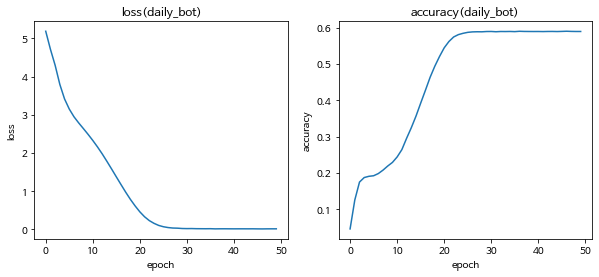

time : 103.67180109024048


In [253]:
start=time.time()

daily_bot = model_train(make_dataset(df0["Q_enc"],df0["A_enc"],MAX_LENGTH = 11,BATCH_SIZE = 64,BUFFER_SIZE = 12000), 
                     hyper_param=hyper_param3_2)

draw_training_history("daily_bot",daily_bot)

period=time.time() - start

model_time["daily_bot"]=period

print("time :", period)

In [254]:
test_output_daily=[sentence_generation(i,daily_bot) for i in test_sentences]
test_df["pred_daily_bot"]=test_output_daily

입력 : 피곤하다
출력 : 울적 . . . . 우울할땐 . . . . 울면
------------------------------------------------------------
입력 : 오늘 뭐 먹지?
출력 : 색다른걸 드셔보세요 .
------------------------------------------------------------
입력 : 1년을 사귀었는데 헤어졌어
출력 : 먼저 생활패턴을 살펴 보세요 .
------------------------------------------------------------
입력 : 남자친구가 연락이 없어
출력 : 한번더 연락해 보세요 .
------------------------------------------------------------
입력 : 짝사랑 중이야
출력 : 저랑 놀아요 .
------------------------------------------------------------
입력 : 회사가기 싫어
출력 : 회사는 친구 사귀는 곳이 아니에요 .
------------------------------------------------------------
입력 : 여자친구랑 놀러갈꺼야
출력 : 누구나 해요 .
------------------------------------------------------------
입력 : 아메리카노 마시고 싶다
출력 : 마시면 좋죠 .
------------------------------------------------------------
입력 : 좋아하는 사람이 생겼어
출력 : 슬픈 이야기네요 .
------------------------------------------------------------
입력 : 고백할까?
출력 : 실천이 말보다 낫죠 .
------------------------------------------------------------


## 연애봇

최대문장 길이: 11
단어장의 크기 : 8171
필터링 후의 질문 샘플 개수: 5239
필터링 후의 답변 샘플 개수: 5239


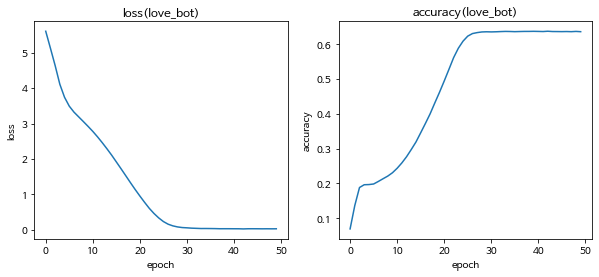

time : 107.65986704826355


In [255]:
start=time.time()

love_bot = model_train(make_dataset(df1["Q_enc"],df1["A_enc"],MAX_LENGTH = 11,BATCH_SIZE = 64,BUFFER_SIZE = 12000), 
                     hyper_param=hyper_param3_2)

draw_training_history("love_bot",love_bot)

period=time.time() - start

model_time["love_bot"]=period

print("time :", period)

In [256]:
test_output_love=[sentence_generation(i,love_bot) for i in test_sentences]
test_df["pred_love_bot"]=test_output_love

입력 : 피곤하다
출력 : 너무 자책하지 마세요 .
------------------------------------------------------------
입력 : 오늘 뭐 먹지?
출력 : 슬픈 일이에요 .
------------------------------------------------------------
입력 : 1년을 사귀었는데 헤어졌어
출력 : 더 마음이 허절할 거예요 .
------------------------------------------------------------
입력 : 남자친구가 연락이 없어
출력 : 먼저 연락을 해보세요 .
------------------------------------------------------------
입력 : 짝사랑 중이야
출력 : 진정으로 사랑한다면 그 사람도 당신의 사랑을 알아볼거예요 .
------------------------------------------------------------
입력 : 회사가기 싫어
출력 : 가지마요 . 같이 라면 먹고 가요 .
------------------------------------------------------------
입력 : 여자친구랑 놀러갈꺼야
출력 : 아프네요 .
------------------------------------------------------------
입력 : 아메리카노 마시고 싶다
출력 : 너무 분위기 의지해보세요 .
------------------------------------------------------------
입력 : 좋아하는 사람이 생겼어
출력 : 축하해요 . 예쁜 사랑하길 바라요 .
------------------------------------------------------------
입력 : 고백할까?
출력 : 선물을 주면서 솔직하고 당당하게 고백해보세요 .
------------------------------------------------------------


In [258]:
test_df[["Q","pred_daily_bot","pred_love_bot"]]

,Q,pred_daily_bot,pred_love_bot
0,피곤하다,울적 . . . . 우울할땐 . . . . 울면,너무 자책하지 마세요 .
1,오늘 뭐 먹지?,색다른걸 드셔보세요 .,슬픈 일이에요 .
2,1년을 사귀었는데 헤어졌어,먼저 생활패턴을 살펴 보세요 .,더 마음이 허절할 거예요 .
3,남자친구가 연락이 없어,한번더 연락해 보세요 .,먼저 연락을 해보세요 .
4,짝사랑 중이야,저랑 놀아요 .,진정으로 사랑한다면 그 사람도 당신의 사랑을 알아볼거예요 .
5,회사가기 싫어,회사는 친구 사귀는 곳이 아니에요 .,가지마요 . 같이 라면 먹고 가요 .
6,여자친구랑 놀러갈꺼야,누구나 해요 .,아프네요 .
7,아메리카노 마시고 싶다,마시면 좋죠 .,너무 분위기 의지해보세요 .
8,좋아하는 사람이 생겼어,슬픈 이야기네요 .,축하해요 . 예쁜 사랑하길 바라요 .
9,고백할까?,실천이 말보다 낫죠 .,선물을 주면서 솔직하고 당당하게 고백해보세요 .


- pred_daily_bot은 일상생활 대화 데이터만 가지고 만든 봇이고, pred_love_bot은 연애관련 대화 데이터만 가지고 만든 봇이다. 모델을 새로 학습 시킬 때마다 weight이 바뀌기 때문에 같은 하이퍼파라미터와 같은 트랜스포머로 모델을 만들었지만 같은 질문에 다른 대답을 하게 되는 것을 어쩔수 없지만 대화의 패턴을 살펴보아야겠다고 생각했다.

__일상대화봇(pred_daily_bot)__
- 일상 관련 질문(오늘 뭐 먹지?, 회사가기 싫어) 같은 질문에 대해서는 기존의 답들과 다름없이 답을 하고 위에서 보았던 것처럼 엉뚱하게 "열정적인 사랑을 하고 계시는 군요"라는 사랑 관련한 답을 하지 않는다. 그래서 일상 대화에 관련한 질문에 대해서는 답변의 질이 좋아진 편이라고 생각한다.
- 연애 관련한 답에 대해서는 "남자친구가 연락이 없어"에 대해서 연애봇(pred_love_bot)과 비슷하게 __한번 더 연락해 보세요__ 라고 나쁘지 않게 답을 했다.
- 하지만 "짝사랑 중이야"라는 질문에 대해서는 __저랑 놀아요__ 라고 답하는 것을 알수 있다. 생각해보면 무뚝뚝하게 달래는 친구처럼 느껴지기도 하지만 보통 짝사랑한다고 고민을 털어놓는 사람에게 내놓는 답은 아니기 때문에 적절한 답은 아닌거 같다.
- 또한 일상봇은 좋아하는 사람이 생겼다는 질문에 __"슬픈 이야기네요"__ 라는 엉뚱한 답을 했다.
- 일상대화로만 학습이 된 챗봇이기 때문에 __연애에 관련해서 감정적으로 공감하는 대화는 안하는 것으로 보여진다.__

__연애대화봇(pred_love_bot)__
- 연애관련한 질문에 대해서는 문법이 조금 틀리긴 해도 적절한 답을 한다.(ex/ Q: 1년을 사귀었는데 헤어졌어, A: 더 마음이 허절할 거예요)
- 반면에 일상관련한 질문에서는 일상대화봇과 달리 서툴게 답을 하는 것으로 보인다.


이처럼 데이터를 나눠서 모델을 만들어보니까, 관련한 데이터가 들어있는 질문에 대해서는 답을 적절하게 잘하지만 해당 분야에 관한 대화가 없는 데이터셋은 엉뚱한 답을 하는 것을 볼수 있다. 요즘 챗봇 서비스를 할때 모든 분야에 대해서 서비스하는 시리와 같은 서비스도 있지만 어떤 특정 분야의 특정 서비스의 업무만 처리하는 챗봇이 작동하는 이유를 알것 같았다. 

## 회고

- 적은 양의 데이터일 경우는 차라리 분명한 목적과 업무를 목적으로 서비스를 설계하고 그 업무를 확실하게 처리할 수 있는 데이터셋을 설계하는 것이 훨씬 경제적이고 합리적인 설계라고 생각이 들었다. 
- 최근 집의 통신사의 TV서비스를 요금제로 묶기 위해서 통신사를 바꾸려고 했는데 부모님께서 __기존 통신사의 음성 챗봇의 서비스가 새로운 통신사에 비해서 사용하기 편하기 때문에 통신사를 바꾸지 않기로 결정__ 하시는 것을 보았다. 보면서 인공지능이 해야하는 일에 대해서 다시 생각해보았다. 정말 딱 하나였는데 __음성인식으로 바로 유튜브 검색이 가능하다는 이유로 통신사 이동을 하지 않았다__  생각해보면 __매우 어려운 기술이 아니라 안정적인 서비스를 사람들이 사용하기 쉽도록 설계__ 를 했기 때문에 구매를 지속했던 것 같다.
- 물론 하나의 사례이지만 인공지능 서비스를 기획할때 모든 범위의 서비스를 잘 하겠다는 목표보다는 __확실하게 분명한 업무이고, 반복되는 불편한 업무를 해소하는 것__ 을 목표로 모델을 만드는 것이 경제적인 모델이 되지 않을까 생각을 해보았다.

## 추가: 하이퍼 파라미터 변화에 따른 훈련시간 비교

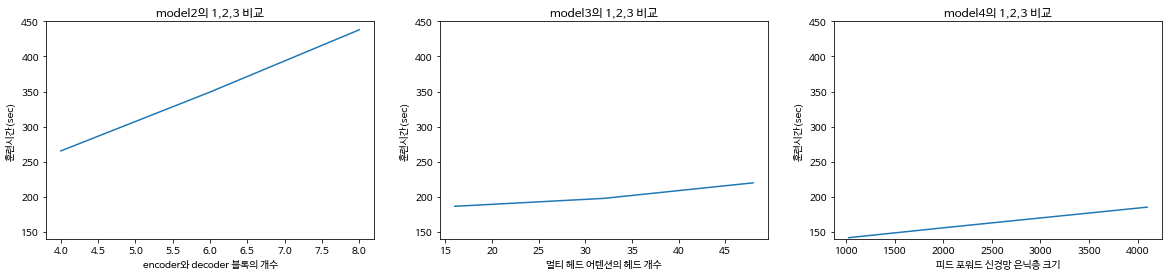

In [243]:
plt.figure(figsize=(20,4))

plt.subplot(1,3,1)
plt.plot([4,6,8],[model_time["model2_1"],model_time["model2_2"],model_time["model2_3"]])
plt.xlabel("encoder와 decoder 블록의 개수")
plt.ylabel("훈련시간(sec)")
plt.title("model2의 1,2,3 비교")
plt.ylim(140,450)

plt.subplot(1,3,2)
plt.plot([16,32,48],[model_time["model3_1"],model_time["model3_2"],model_time["model3_3"]])
plt.xlabel("멀티 헤드 어텐션의 헤드 개수")
plt.ylabel("훈련시간(sec)")
plt.ylim(140,450)
plt.title("model3의 1,2,3 비교")


plt.subplot(1,3,3)
plt.plot([1024,2048,4098],[model_time["model4_1"],model_time["model4_2"],model_time["model4_3"]])
plt.xlabel("피드 포워드 신경망 은닉층 크기")
plt.ylabel("훈련시간(sec)")
plt.ylim(140,450)
plt.title("model4의 1,2,3 비교")


plt.show()

- 모델을 튜닝하는 과정에서 __1. 인코더, 디코더 블록의 개수(model2_X)__ 와 __2. 멀티 헤드 어텐션의 헤드 개수(model3_X), 3. 피드 포워드 신경망의 은닉층 크기(model4_X)__ 를 바꿔가면서 모델을 만들어보았다., 
- model2_1, model2_2, model2_3은 트랜스포머 내부의 __인코더와 디코더 블록(혹은 레이어) 개수__ 를 4,6,8로 바꿔가면서 모델을 돌렸다.  바꿔도 훈련시간이 급증하고, 